# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,"52,356",59972
1,2015-01-02,"47,811",56277
2,2015-01-03,"49,555",60035
3,2015-01-04,"57,680",62548
4,2015-01-05,"50,193",58566


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3012 non-null   datetime64[ns]
 1   y       3012 non-null   float64       
 2   seat    3012 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 70.7 KB


<AxesSubplot:xlabel='ds'>

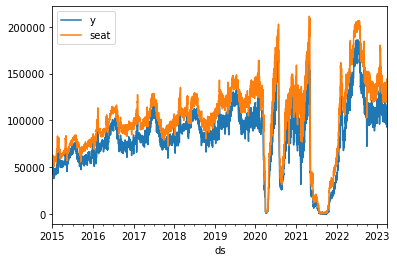

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays2.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

## 2.1. Neural prophet

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,100),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,40),
        'n_lags':trial.suggest_int('n_lags',1,365),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3),
        'loss_func':trial.suggest_categorical('loss_func',['Huber', 'MAE'])
    }
    events_params_1 = {'regularization':trial.suggest_float('event1_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event1_mode',['multiplicative', 'additive'])}
    events_params_2 = {'regularization':trial.suggest_float('event2_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event2_mode',['multiplicative', 'additive'])}  
    lagged_regressor_params = {'regularization':trial.suggest_float('lagged_regularization',0,0.8),
                               'normalize':trial.suggest_categorical('lagged_normalize',['auto',True,False]),
                               'n_lags':trial.suggest_int('lagged_n_lags',1,365)}
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)  
    optuna_model.add_events(events = ['Lunar','Labor','Summer','new_year'], **events_params_2)
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [12]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-24 17:06:11,638] A new study created in memory with name: no-name-cd9b3504-0736-4fc4-8ef7-1bb06228459b


In [13]:
study.optimize(objective, n_trials=300)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 152


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:09:07,760] Trial 0 finished with value: 43983.0 and parameters: {'trend_reg': 67.22818358452055, 'seasonality_reg': 48.85903208413432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 23, 'n_lags': 109, 'ar_reg': 0.46695720506953253, 'learning_rate': 9.906283367308491, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.07548778726699304, 'event1_mode': 'additive', 'event2_regularization': 0.07909080886916407, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.07489047463820207, 'lagged_normalize': 'auto', 'lagged_n_lags': 107}. Best is trial 0 with value: 43983.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:12:04,227] Trial 1 finished with value: 13382.0 and parameters: {'trend_reg': 81.61441985635884, 'seasonality_reg': 82.82145236406046, 'seasonality_mode': 'additive', 'yearly_seasonality': 12, 'weekly_seasonality': 17, 'n_lags': 36, 'ar_reg': 1.4401099890768465, 'learning_rate': 2.1227495569802546, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.00131060053623282, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0335093255428607, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03340682503539192, 'lagged_normalize': False, 'lagged_n_lags': 305}. Best is trial 1 with value: 13382.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:15:22,280] Trial 2 finished with value: 197487.0 and parameters: {'trend_reg': 25.263970383008104, 'seasonality_reg': 96.83052392625086, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 16, 'n_lags': 75, 'ar_reg': 9.15462498979845, 'learning_rate': 9.391835051430231, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.17026879813435714, 'event1_mode': 'additive', 'event2_regularization': 0.12831402015469273, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5092960821691669, 'lagged_normalize': True, 'lagged_n_lags': 111}. Best is trial 1 with value: 13382.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:17:42,850] Trial 3 finished with value: 70003.0 and parameters: {'trend_reg': 71.85091947140288, 'seasonality_reg': 95.80220189401467, 'seasonality_mode': 'additive', 'yearly_seasonality': 11, 'weekly_seasonality': 35, 'n_lags': 254, 'ar_reg': 8.265585239711491, 'learning_rate': 9.183563138936316, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.10325058166133659, 'event1_mode': 'additive', 'event2_regularization': 0.04705330788557452, 'event2_mode': 'additive', 'lagged_regularization': 0.1949250432241333, 'lagged_normalize': 'auto', 'lagged_n_lags': 130}. Best is trial 1 with value: 13382.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:21:04,268] Trial 4 finished with value: 126002.0 and parameters: {'trend_reg': 10.347529588588547, 'seasonality_reg': 29.95805191966476, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 15, 'n_lags': 272, 'ar_reg': 6.481588203970642, 'learning_rate': 7.700606267804263, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.19907297612171931, 'event1_mode': 'additive', 'event2_regularization': 0.030924026629826185, 'event2_mode': 'additive', 'lagged_regularization': 0.3798100502157203, 'lagged_normalize': 'auto', 'lagged_n_lags': 265}. Best is trial 1 with value: 13382.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:24:35,847] Trial 5 finished with value: 13297.0 and parameters: {'trend_reg': 75.1356197915079, 'seasonality_reg': 61.54243708004303, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 34, 'n_lags': 242, 'ar_reg': 5.164365326761173, 'learning_rate': 7.72603262272927, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.04982746843210631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12358177987389328, 'event2_mode': 'additive', 'lagged_regularization': 0.5624746619691513, 'lagged_normalize': False, 'lagged_n_lags': 353}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:27:38,279] Trial 6 finished with value: 28115.0 and parameters: {'trend_reg': 65.76190679343033, 'seasonality_reg': 17.490694181200524, 'seasonality_mode': 'additive', 'yearly_seasonality': 37, 'weekly_seasonality': 9, 'n_lags': 346, 'ar_reg': 2.317612521475123, 'learning_rate': 1.5385931612874733, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.028560800053275482, 'event1_mode': 'additive', 'event2_regularization': 0.19265396892882455, 'event2_mode': 'additive', 'lagged_regularization': 0.7495088265435883, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:29:52,494] Trial 7 finished with value: 612553142.0 and parameters: {'trend_reg': 68.50236999159925, 'seasonality_reg': 71.3416659736247, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 21, 'n_lags': 344, 'ar_reg': 7.344702588756018, 'learning_rate': 1.6455792266055806, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.13487293525572117, 'event1_mode': 'additive', 'event2_regularization': 0.13980652517216646, 'event2_mode': 'additive', 'lagged_regularization': 0.3510608165904892, 'lagged_normalize': True, 'lagged_n_lags': 146}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:32:49,503] Trial 8 finished with value: 50029.0 and parameters: {'trend_reg': 81.74720442313338, 'seasonality_reg': 3.9365855906648717, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 5, 'n_lags': 56, 'ar_reg': 6.086250249089369, 'learning_rate': 8.472715528262817, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.10192923113249969, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07248433342289813, 'event2_mode': 'additive', 'lagged_regularization': 0.62557599303809, 'lagged_normalize': False, 'lagged_n_lags': 317}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:36:03,498] Trial 9 finished with value: 73514.0 and parameters: {'trend_reg': 92.47803877492402, 'seasonality_reg': 4.300689591853499, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 28, 'n_lags': 361, 'ar_reg': 1.5354461964236843, 'learning_rate': 3.3326224070911303, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.1742421286752273, 'event1_mode': 'additive', 'event2_regularization': 0.025338283997763944, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.32197827561336745, 'lagged_normalize': 'auto', 'lagged_n_lags': 154}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:39:33,011] Trial 10 finished with value: 23950.0 and parameters: {'trend_reg': 41.51139158959476, 'seasonality_reg': 55.25728553428909, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 40, 'n_lags': 165, 'ar_reg': 4.248005471569033, 'learning_rate': 5.882097169361287, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.052995987615135416, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1771584869563537, 'event2_mode': 'additive', 'lagged_regularization': 0.7994665718346075, 'lagged_normalize': False, 'lagged_n_lags': 25}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:42:43,630] Trial 11 finished with value: 20816.0 and parameters: {'trend_reg': 99.23203508362789, 'seasonality_reg': 72.37956584860422, 'seasonality_mode': 'additive', 'yearly_seasonality': 18, 'weekly_seasonality': 29, 'n_lags': 206, 'ar_reg': 4.0136456533050895, 'learning_rate': 5.295336655762997, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.012060591535850143, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11472725163136102, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.017991093313061833, 'lagged_normalize': False, 'lagged_n_lags': 358}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:45:31,485] Trial 12 finished with value: 14292.0 and parameters: {'trend_reg': 45.407678503304034, 'seasonality_reg': 76.45460888063322, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 13, 'n_lags': 1, 'ar_reg': 3.073245741913011, 'learning_rate': 3.511819095287548, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0035479600407557557, 'event1_mode': 'multiplicative', 'event2_regularization': 0.004915421829937122, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5327290293469041, 'lagged_normalize': False, 'lagged_n_lags': 356}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wit

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:48:23,841] Trial 13 finished with value: 31950.0 and parameters: {'trend_reg': 83.66917124811684, 'seasonality_reg': 56.73704955157432, 'seasonality_mode': 'additive', 'yearly_seasonality': 10, 'weekly_seasonality': 27, 'n_lags': 156, 'ar_reg': 5.8754010731610755, 'learning_rate': 6.722729140383154, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.04799750802288477, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1596874678639013, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.20073337686911902, 'lagged_normalize': False, 'lagged_n_lags': 278}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:51:32,727] Trial 14 finished with value: 457221.0 and parameters: {'trend_reg': 55.28865191254731, 'seasonality_reg': 81.2523430715267, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 34, 'n_lags': 233, 'ar_reg': 0.014284994740140888, 'learning_rate': 0.024841741645790894, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03898058266345841, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09397340228155435, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5986498301448858, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:54:56,820] Trial 15 finished with value: 17703.0 and parameters: {'trend_reg': 82.9775718976519, 'seasonality_reg': 34.438304074657424, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 305, 'ar_reg': 4.888287491098197, 'learning_rate': 3.927274196790247, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.07569336455121115, 'event1_mode': 'multiplicative', 'event2_regularization': 0.057659752893060974, 'event2_mode': 'additive', 'lagged_regularization': 0.24978474255041647, 'lagged_normalize': False, 'lagged_n_lags': 306}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 17:58:05,695] Trial 16 finished with value: 24094.0 and parameters: {'trend_reg': 55.837584025214824, 'seasonality_reg': 86.17339011725, 'seasonality_mode': 'additive', 'yearly_seasonality': 32, 'weekly_seasonality': 4, 'n_lags': 123, 'ar_reg': 2.8459122443071942, 'learning_rate': 7.154364443557338, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.015679488871356867, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1020412061148549, 'event2_mode': 'additive', 'lagged_regularization': 0.486577307684083, 'lagged_normalize': True, 'lagged_n_lags': 316}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INF

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:01:06,570] Trial 17 finished with value: 17256.0 and parameters: {'trend_reg': 34.44352540921388, 'seasonality_reg': 63.48723448651552, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 18, 'n_lags': 14, 'ar_reg': 1.7742001586914253, 'learning_rate': 2.180686550117438, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0672027248365519, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14202268848016492, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.678869718483947, 'lagged_normalize': False, 'lagged_n_lags': 220}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:03:54,252] Trial 18 finished with value: 26817.0 and parameters: {'trend_reg': 85.97366163477156, 'seasonality_reg': 39.170132765880886, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 11, 'n_lags': 213, 'ar_reg': 9.968264863834172, 'learning_rate': 0.35026658635562224, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.02899891743951961, 'event1_mode': 'multiplicative', 'event2_regularization': 0.000727381411590608, 'event2_mode': 'additive', 'lagged_regularization': 0.10453508968091593, 'lagged_normalize': False, 'lagged_n_lags': 265}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:06:19,897] Trial 19 finished with value: 2160970429.0 and parameters: {'trend_reg': 74.83549572489989, 'seasonality_reg': 89.30699082042608, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 24, 'n_lags': 304, 'ar_reg': 3.7146964564816747, 'learning_rate': 4.5163774773623055, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.0009889009480434433, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09489960525516025, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.43964328763583843, 'lagged_normalize': False, 'lagged_n_lags': 358}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.77% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.77% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:09:42,950] Trial 20 finished with value: 32393.0 and parameters: {'trend_reg': 99.37681718246861, 'seasonality_reg': 63.777044820050165, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 33, 'n_lags': 70, 'ar_reg': 5.13334026233204, 'learning_rate': 6.148150535676679, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.12358482269112366, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15856920233130564, 'event2_mode': 'additive', 'lagged_regularization': 0.5844700463718577, 'lagged_normalize': True, 'lagged_n_lags': 67}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
IN

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:12:19,399] Trial 21 finished with value: 14277.0 and parameters: {'trend_reg': 44.97376196841026, 'seasonality_reg': 74.86293512073863, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 10, 'n_lags': 11, 'ar_reg': 2.665285800818767, 'learning_rate': 3.008372103932018, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0009896904003891586, 'event1_mode': 'multiplicative', 'event2_regularization': 0.00304036166389271, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5154526070198854, 'lagged_normalize': False, 'lagged_n_lags': 365}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:14:54,709] Trial 22 finished with value: 13944.0 and parameters: {'trend_reg': 59.34428342916756, 'seasonality_reg': 66.98164764691738, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 9, 'n_lags': 22, 'ar_reg': 1.221608426055043, 'learning_rate': 2.3114645104014557, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.026744156043849006, 'event1_mode': 'multiplicative', 'event2_regularization': 0.022812500624805335, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.4548561217145153, 'lagged_normalize': False, 'lagged_n_lags': 321}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:17:27,081] Trial 23 finished with value: 13730.0 and parameters: {'trend_reg': 58.0289459389274, 'seasonality_reg': 44.32354041016876, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 7, 'n_lags': 44, 'ar_reg': 1.2334018970633993, 'learning_rate': 2.4561398430858326, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.02592751229400324, 'event1_mode': 'multiplicative', 'event2_regularization': 0.029588886644329997, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.43221989908545927, 'lagged_normalize': False, 'lagged_n_lags': 321}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:19:48,366] Trial 24 finished with value: 128179.0 and parameters: {'trend_reg': 60.262303650780666, 'seasonality_reg': 43.44485757779438, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 1, 'n_lags': 97, 'ar_reg': 0.8323530931043539, 'learning_rate': 0.9713447941491498, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.05856035808327385, 'event1_mode': 'multiplicative', 'event2_regularization': 0.04988736164883059, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.3104799317667396, 'lagged_normalize': False, 'lagged_n_lags': 285}. Best is trial 5 with value: 13297.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wit

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:22:40,602] Trial 25 finished with value: 13204.0 and parameters: {'trend_reg': 72.94124008543639, 'seasonality_reg': 52.99997308001525, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 18, 'n_lags': 47, 'ar_reg': 2.1056674774639177, 'learning_rate': 4.5821646108075145, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.03948763300209662, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0727090760167127, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.7089538161949231, 'lagged_normalize': False, 'lagged_n_lags': 247}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:25:41,351] Trial 26 finished with value: 37339.0 and parameters: {'trend_reg': 74.47112929548963, 'seasonality_reg': 54.91854634921209, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 18, 'n_lags': 133, 'ar_reg': 5.234259585291909, 'learning_rate': 4.860910008212915, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.08991358705269271, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06763691613237262, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.7041034478806294, 'lagged_normalize': False, 'lagged_n_lags': 241}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:28:05,508] Trial 27 finished with value: 1307866499.0 and parameters: {'trend_reg': 92.6379379584427, 'seasonality_reg': 27.251924456650414, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 20, 'n_lags': 189, 'ar_reg': 3.57883218323523, 'learning_rate': 4.124394333113441, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.043321725057909224, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1133729098567901, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.718868021810652, 'lagged_normalize': False, 'lagged_n_lags': 186}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:31:18,163] Trial 28 finished with value: 49830.0 and parameters: {'trend_reg': 78.15480544825307, 'seasonality_reg': 83.14441742511919, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 25, 'n_lags': 88, 'ar_reg': 1.988474198005008, 'learning_rate': 8.141280585360397, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.062643833296326, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06201164794686364, 'event2_mode': 'additive', 'lagged_regularization': 0.656333043397031, 'lagged_normalize': 'auto', 'lagged_n_lags': 188}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:33:52,523] Trial 29 finished with value: 1587103579.0 and parameters: {'trend_reg': 63.840187898596724, 'seasonality_reg': 48.581853531864574, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 31, 'n_lags': 39, 'ar_reg': 0.5044027074294645, 'learning_rate': 5.405460770758701, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.0825785877072335, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07561646221009705, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.11987195152844765, 'lagged_normalize': True, 'lagged_n_lags': 248}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:36:42,795] Trial 30 finished with value: 14086.0 and parameters: {'trend_reg': 91.2915396012411, 'seasonality_reg': 62.93713012091426, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 22, 'n_lags': 146, 'ar_reg': 6.99456979113471, 'learning_rate': 9.909468468577003, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.016355185591717773, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08752065131848077, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5663701646673329, 'lagged_normalize': 'auto', 'lagged_n_lags': 294}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:39:19,533] Trial 31 finished with value: 13551.0 and parameters: {'trend_reg': 51.91166531048165, 'seasonality_reg': 46.42121287593866, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 14, 'n_lags': 35, 'ar_reg': 1.0464127809399808, 'learning_rate': 2.602789887904992, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.03539577780031499, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03839535989267632, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.3812393168643774, 'lagged_normalize': False, 'lagged_n_lags': 331}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:41:51,797] Trial 32 finished with value: 13762.0 and parameters: {'trend_reg': 27.867609279983206, 'seasonality_reg': 49.30893315378383, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 14, 'n_lags': 37, 'ar_reg': 0.017171759831638767, 'learning_rate': 2.745402584528651, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.037848130559301876, 'event1_mode': 'multiplicative', 'event2_regularization': 0.044079406003610294, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.7957005324578177, 'lagged_normalize': False, 'lagged_n_lags': 335}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:43:57,569] Trial 33 finished with value: 1095074214.0 and parameters: {'trend_reg': 51.796755107348055, 'seasonality_reg': 97.89663964401613, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 18, 'n_lags': 59, 'ar_reg': 4.603925888320494, 'learning_rate': 1.0641439427983692, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.06867908419235674, 'event1_mode': 'multiplicative', 'event2_regularization': 0.04179000690464699, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.25434728786853666, 'lagged_normalize': False, 'lagged_n_lags': 339}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:46:56,085] Trial 34 finished with value: 116543.0 and parameters: {'trend_reg': 15.079442431608385, 'seasonality_reg': 58.48714689092006, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 16, 'n_lags': 105, 'ar_reg': 3.283432385993126, 'learning_rate': 8.979999477723393, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.12088000340241492, 'event1_mode': 'additive', 'event2_regularization': 0.11035479713730573, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.04398560275392653, 'lagged_normalize': False, 'lagged_n_lags': 292}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:50:00,982] Trial 35 finished with value: 21045.0 and parameters: {'trend_reg': 71.47358957472979, 'seasonality_reg': 24.308533881224257, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 12, 'n_lags': 262, 'ar_reg': 2.2465122145066223, 'learning_rate': 3.717104654952497, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.018751369543558896, 'event1_mode': 'additive', 'event2_regularization': 0.014679105843440912, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6476072334609383, 'lagged_normalize': False, 'lagged_n_lags': 269}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:53:05,702] Trial 36 finished with value: 43419.0 and parameters: {'trend_reg': 66.59284580626725, 'seasonality_reg': 37.02309841556304, 'seasonality_mode': 'additive', 'yearly_seasonality': 12, 'weekly_seasonality': 19, 'n_lags': 87, 'ar_reg': 1.0091130353836555, 'learning_rate': 4.446998424114015, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.03829520642548277, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08475888538026452, 'event2_mode': 'additive', 'lagged_regularization': 0.1773660693302823, 'lagged_normalize': 'auto', 'lagged_n_lags': 338}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:55:59,028] Trial 37 finished with value: 971609978.0 and parameters: {'trend_reg': 79.76273801290434, 'seasonality_reg': 44.03807754842285, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 37, 'n_lags': 237, 'ar_reg': 8.403497523269818, 'learning_rate': 1.6604326344451454, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.090024199784557, 'event1_mode': 'additive', 'event2_regularization': 0.12853675465428943, 'event2_mode': 'additive', 'lagged_regularization': 0.5484125624605918, 'lagged_normalize': True, 'lagged_n_lags': 201}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 18:59:02,883] Trial 38 finished with value: 71553.0 and parameters: {'trend_reg': 88.13506389807176, 'seasonality_reg': 91.58513655242146, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 15, 'n_lags': 283, 'ar_reg': 5.676742913125787, 'learning_rate': 7.3499424854540685, 'num_hidden_layers': 1, 'loss_func': 'Huber', 'event1_regularization': 0.04694535810620106, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05212567051437228, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.39364668227769567, 'lagged_normalize': False, 'lagged_n_lags': 252}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:02:15,441] Trial 39 finished with value: 174497.0 and parameters: {'trend_reg': 35.10496429376378, 'seasonality_reg': 50.951147290592814, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 26, 'n_lags': 68, 'ar_reg': 1.6999365458996851, 'learning_rate': 6.453110418070251, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.14750696139265285, 'event1_mode': 'additive', 'event2_regularization': 0.032493371417632866, 'event2_mode': 'additive', 'lagged_regularization': 0.7421785106182811, 'lagged_normalize': False, 'lagged_n_lags': 295}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:05:30,681] Trial 40 finished with value: 13652.0 and parameters: {'trend_reg': 70.25444149289369, 'seasonality_reg': 67.44781545171355, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 23, 'n_lags': 182, 'ar_reg': 2.461710521606358, 'learning_rate': 3.144523764760816, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.030934307790517725, 'event1_mode': 'multiplicative', 'event2_regularization': 0.04115709332371469, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6222975378195759, 'lagged_normalize': 'auto', 'lagged_n_lags': 343}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:08:31,268] Trial 41 finished with value: 13878.0 and parameters: {'trend_reg': 71.12892320985216, 'seasonality_reg': 67.70876099896498, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 23, 'n_lags': 30, 'ar_reg': 2.594933043560635, 'learning_rate': 2.925258053333265, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.03143586315308438, 'event1_mode': 'multiplicative', 'event2_regularization': 0.04050448225075039, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6177363842087511, 'lagged_normalize': 'auto', 'lagged_n_lags': 342}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:11:40,713] Trial 42 finished with value: 14314.0 and parameters: {'trend_reg': 77.14400916217944, 'seasonality_reg': 77.36983060126077, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 16, 'n_lags': 186, 'ar_reg': 2.273992228025156, 'learning_rate': 1.9725720267530265, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.010348042321678633, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0204082472768283, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.7667324113199244, 'lagged_normalize': 'auto', 'lagged_n_lags': 307}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:14:46,927] Trial 43 finished with value: 17751.0 and parameters: {'trend_reg': 66.0089403051509, 'seasonality_reg': 59.815199083578165, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 21, 'n_lags': 122, 'ar_reg': 0.5623842351764066, 'learning_rate': 3.3789963907696974, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.05753871579613008, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03516527812974543, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6843648641056939, 'lagged_normalize': 'auto', 'lagged_n_lags': 330}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:18:05,906] Trial 44 finished with value: 17254.0 and parameters: {'trend_reg': 2.478549444536746, 'seasonality_reg': 69.25268751402142, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 29, 'n_lags': 56, 'ar_reg': 1.3199529309874507, 'learning_rate': 5.637485419427591, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.02169514676121052, 'event1_mode': 'multiplicative', 'event2_regularization': 0.014361541668232475, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.49884763373519697, 'lagged_normalize': 'auto', 'lagged_n_lags': 159}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:21:03,929] Trial 45 finished with value: 92811.0 and parameters: {'trend_reg': 69.85617967868357, 'seasonality_reg': 53.4580096550361, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 37, 'n_lags': 1, 'ar_reg': 6.493300984435064, 'learning_rate': 1.3529451966630877, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.049947109790830314, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06702751831306925, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6355068529021785, 'lagged_normalize': 'auto', 'lagged_n_lags': 347}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:23:03,975] Trial 46 finished with value: 2294724820.0 and parameters: {'trend_reg': 63.002735991788015, 'seasonality_reg': 10.50109498901773, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 13, 'n_lags': 323, 'ar_reg': 4.29003247646399, 'learning_rate': 4.805786859692365, 'num_hidden_layers': 0, 'loss_func': 'Huber', 'event1_regularization': 0.1997551940186176, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05468598307724165, 'event2_mode': 'additive', 'lagged_regularization': 0.37281884128916204, 'lagged_normalize': False, 'lagged_n_lags': 309}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wit

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:26:00,886] Trial 47 finished with value: 20157.0 and parameters: {'trend_reg': 51.55352497982936, 'seasonality_reg': 79.96598490903976, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 16, 'n_lags': 241, 'ar_reg': 3.3743784480323455, 'learning_rate': 3.2475011277373023, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.01098742395264593, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13025974459427847, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.316660892113218, 'lagged_normalize': False, 'lagged_n_lags': 273}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:29:00,050] Trial 48 finished with value: 25110.0 and parameters: {'trend_reg': 81.48228169447387, 'seasonality_reg': 73.98245356415231, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 7, 'n_lags': 177, 'ar_reg': 1.967728219812246, 'learning_rate': 2.627737784665742, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.03528192024287706, 'event1_mode': 'additive', 'event2_regularization': 0.1052981224315829, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6087303141371404, 'lagged_normalize': True, 'lagged_n_lags': 113}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:32:11,514] Trial 49 finished with value: 13468.0 and parameters: {'trend_reg': 94.4011374867494, 'seasonality_reg': 61.03199798161083, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 31, 'n_lags': 213, 'ar_reg': 0.7914072502553179, 'learning_rate': 3.9444735356610843, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.008373006118676786, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11995725573249387, 'event2_mode': 'additive', 'lagged_regularization': 0.1537534827621174, 'lagged_normalize': False, 'lagged_n_lags': 352}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:35:26,272] Trial 50 finished with value: 21033.0 and parameters: {'trend_reg': 94.46792843474898, 'seasonality_reg': 46.516983738392454, 'seasonality_mode': 'additive', 'yearly_seasonality': 18, 'weekly_seasonality': 36, 'n_lags': 209, 'ar_reg': 0.016754650072904553, 'learning_rate': 4.0674183997716336, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.01285744106274647, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14159874164303632, 'event2_mode': 'additive', 'lagged_regularization': 0.0012624813446828198, 'lagged_normalize': False, 'lagged_n_lags': 360}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:38:32,632] Trial 51 finished with value: 13327.0 and parameters: {'trend_reg': 88.03388904766035, 'seasonality_reg': 60.43290132594503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 32, 'n_lags': 227, 'ar_reg': 1.5433806620552097, 'learning_rate': 4.310201603732105, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.008390987971639473, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1195079357473595, 'event2_mode': 'additive', 'lagged_regularization': 0.07489601278559552, 'lagged_normalize': False, 'lagged_n_lags': 328}. Best is trial 25 with value: 13204.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:41:42,852] Trial 52 finished with value: 12999.0 and parameters: {'trend_reg': 87.26062791336072, 'seasonality_reg': 58.574408215868665, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 31, 'n_lags': 281, 'ar_reg': 0.7709508053850418, 'learning_rate': 5.222731392696206, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.007127707842470802, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12510198670129535, 'event2_mode': 'additive', 'lagged_regularization': 0.07911477957383577, 'lagged_normalize': False, 'lagged_n_lags': 328}. Best is trial 52 with value: 12999.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:44:52,384] Trial 53 finished with value: 13277.0 and parameters: {'trend_reg': 86.00338063047694, 'seasonality_reg': 60.62584193832047, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 31, 'n_lags': 272, 'ar_reg': 0.4838953350311932, 'learning_rate': 5.231963381808666, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.005755338244218585, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12036778937082517, 'event2_mode': 'additive', 'lagged_regularization': 0.08877624216228562, 'lagged_normalize': False, 'lagged_n_lags': 303}. Best is trial 52 with value: 12999.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:48:01,089] Trial 54 finished with value: 13360.0 and parameters: {'trend_reg': 88.61758425449712, 'seasonality_reg': 53.356534570935004, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 32, 'n_lags': 287, 'ar_reg': 1.5086313685909374, 'learning_rate': 5.13595949753407, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.000425379062955371, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12232602725605567, 'event2_mode': 'additive', 'lagged_regularization': 0.05503148192433804, 'lagged_normalize': False, 'lagged_n_lags': 301}. Best is trial 52 with value: 12999.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:51:09,492] Trial 55 finished with value: 13370.0 and parameters: {'trend_reg': 86.74947315452444, 'seasonality_reg': 53.115509676883185, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 32, 'n_lags': 282, 'ar_reg': 1.5561773937959487, 'learning_rate': 5.202129692830858, 'num_hidden_layers': 1, 'loss_func': 'MAE', 'event1_regularization': 0.00673652944758196, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15217539332147173, 'event2_mode': 'additive', 'lagged_regularization': 0.06741933018403629, 'lagged_normalize': False, 'lagged_n_lags': 298}. Best is trial 52 with value: 12999.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:54:27,289] Trial 56 finished with value: 13067.0 and parameters: {'trend_reg': 97.329844211406, 'seasonality_reg': 56.95346384166825, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 29, 'n_lags': 251, 'ar_reg': 0.2989407868411029, 'learning_rate': 4.551620814895531, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.021108254439617474, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1198840478514331, 'event2_mode': 'additive', 'lagged_regularization': 0.09769992912175096, 'lagged_normalize': False, 'lagged_n_lags': 255}. Best is trial 52 with value: 12999.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 19:57:53,150] Trial 57 finished with value: 12973.0 and parameters: {'trend_reg': 96.42840301986192, 'seasonality_reg': 58.57133811829192, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 35, 'n_lags': 261, 'ar_reg': 0.3733542175271249, 'learning_rate': 4.5728337116768225, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.022143604259751815, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15110871654399072, 'event2_mode': 'additive', 'lagged_regularization': 0.10020143687601715, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 57 with value: 12973.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:01:28,925] Trial 58 finished with value: 19806.0 and parameters: {'trend_reg': 96.79503799662545, 'seasonality_reg': 56.68485258270361, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 35, 'n_lags': 263, 'ar_reg': 0.36978033090648266, 'learning_rate': 5.982650527010704, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.021830149257534466, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1795212309064469, 'event2_mode': 'additive', 'lagged_regularization': 0.1198776588583453, 'lagged_normalize': False, 'lagged_n_lags': 214}. Best is trial 57 with value: 12973.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:04:51,437] Trial 59 finished with value: 13321.0 and parameters: {'trend_reg': 99.13680242653469, 'seasonality_reg': 40.26016486819056, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 29, 'n_lags': 310, 'ar_reg': 0.3997197086055774, 'learning_rate': 6.804388232976494, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.022337253013696923, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13670124222031504, 'event2_mode': 'additive', 'lagged_regularization': 0.09408542676459306, 'lagged_normalize': False, 'lagged_n_lags': 235}. Best is trial 57 with value: 12973.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:08:14,266] Trial 60 finished with value: 12880.0 and parameters: {'trend_reg': 83.66712737750508, 'seasonality_reg': 64.88637111833822, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 39, 'n_lags': 249, 'ar_reg': 0.6465876481490084, 'learning_rate': 4.688470165322021, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04319446297413011, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15309296241145195, 'event2_mode': 'additive', 'lagged_regularization': 0.22338616827146757, 'lagged_normalize': False, 'lagged_n_lags': 251}. Best is trial 60 with value: 12880.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:11:35,903] Trial 61 finished with value: 12846.0 and parameters: {'trend_reg': 84.44491130741929, 'seasonality_reg': 71.62187384739983, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 39, 'n_lags': 251, 'ar_reg': 0.7189022681931067, 'learning_rate': 4.706254985004844, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05282160583395944, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17094393246241452, 'event2_mode': 'additive', 'lagged_regularization': 0.2219882202044997, 'lagged_normalize': False, 'lagged_n_lags': 255}. Best is trial 61 with value: 12846.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:14:59,712] Trial 62 finished with value: 13392.0 and parameters: {'trend_reg': 84.72256933162048, 'seasonality_reg': 64.25551229883025, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 38, 'n_lags': 251, 'ar_reg': 0.7051008391052174, 'learning_rate': 5.745391764307988, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.017723654232948735, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17244824215804316, 'event2_mode': 'additive', 'lagged_regularization': 0.14429729936374122, 'lagged_normalize': False, 'lagged_n_lags': 261}. Best is trial 61 with value: 12846.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:18:23,313] Trial 63 finished with value: 13122.0 and parameters: {'trend_reg': 83.8966293264128, 'seasonality_reg': 71.16072918825272, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 39, 'n_lags': 224, 'ar_reg': 0.2902625453203275, 'learning_rate': 4.755484302268496, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04094814507661972, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14878382023674425, 'event2_mode': 'additive', 'lagged_regularization': 0.23531336028165684, 'lagged_normalize': False, 'lagged_n_lags': 226}. Best is trial 61 with value: 12846.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:21:45,836] Trial 64 finished with value: 12451.0 and parameters: {'trend_reg': 89.44339463021525, 'seasonality_reg': 73.32820552441254, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 226, 'ar_reg': 1.006315207344218, 'learning_rate': 4.631982539714881, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05444645196439622, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15129575639319282, 'event2_mode': 'additive', 'lagged_regularization': 0.24354195803016288, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:25:07,075] Trial 65 finished with value: 12674.0 and parameters: {'trend_reg': 91.00339580993948, 'seasonality_reg': 71.77729938025603, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 219, 'ar_reg': 0.22595531096665084, 'learning_rate': 4.917798445762982, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05572354122927432, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16321338036424798, 'event2_mode': 'additive', 'lagged_regularization': 0.2408024092516756, 'lagged_normalize': False, 'lagged_n_lags': 227}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:28:26,280] Trial 66 finished with value: 13096.0 and parameters: {'trend_reg': 90.07855527841909, 'seasonality_reg': 76.92691261063335, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 250, 'ar_reg': 0.9823386638728167, 'learning_rate': 5.539651496686956, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05427014761120582, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17033213632892882, 'event2_mode': 'additive', 'lagged_regularization': 0.21324395975522056, 'lagged_normalize': False, 'lagged_n_lags': 200}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:31:49,616] Trial 67 finished with value: 18854.0 and parameters: {'trend_reg': 96.26222646866191, 'seasonality_reg': 71.25727556163761, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 34, 'n_lags': 195, 'ar_reg': 0.15912591439070264, 'learning_rate': 3.6589699081500404, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07291484181244308, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16223907941746304, 'event2_mode': 'additive', 'lagged_regularization': 0.28269991333421873, 'lagged_normalize': False, 'lagged_n_lags': 167}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:35:11,212] Trial 68 finished with value: 13128.0 and parameters: {'trend_reg': 92.05252287973765, 'seasonality_reg': 65.28888019194423, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 293, 'ar_reg': 0.7702696691993942, 'learning_rate': 6.294067621306563, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06143570839905788, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15073261363323087, 'event2_mode': 'additive', 'lagged_regularization': 0.17221418470634592, 'lagged_normalize': False, 'lagged_n_lags': 202}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:38:29,144] Trial 69 finished with value: 13044.0 and parameters: {'trend_reg': 99.94859461965723, 'seasonality_reg': 84.32629791258128, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 270, 'ar_reg': 1.2971288311088236, 'learning_rate': 4.840522359879242, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04531010322241674, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19560604245280927, 'event2_mode': 'additive', 'lagged_regularization': 0.2662090751854127, 'lagged_normalize': False, 'lagged_n_lags': 210}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:41:44,704] Trial 70 finished with value: 26302.0 and parameters: {'trend_reg': 80.62409784474274, 'seasonality_reg': 86.26873306613496, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 332, 'ar_reg': 1.1776214068232538, 'learning_rate': 4.884213497723301, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.07958222646116, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19423094677076824, 'event2_mode': 'additive', 'lagged_regularization': 0.28100367214129, 'lagged_normalize': True, 'lagged_n_lags': 212}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:45:05,670] Trial 71 finished with value: 13163.0 and parameters: {'trend_reg': 97.82204971935174, 'seasonality_reg': 79.51732950130938, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 36, 'n_lags': 267, 'ar_reg': 0.6593030199601508, 'learning_rate': 4.334125762695303, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04619992044605224, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1667656676566643, 'event2_mode': 'additive', 'lagged_regularization': 0.21773754648481627, 'lagged_normalize': False, 'lagged_n_lags': 227}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:48:25,076] Trial 72 finished with value: 19937.0 and parameters: {'trend_reg': 93.47512038866054, 'seasonality_reg': 93.17460466946554, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 223, 'ar_reg': 1.255025294554019, 'learning_rate': 4.963698803182894, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06819325262595512, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18486359427908453, 'event2_mode': 'additive', 'lagged_regularization': 0.26855420068636016, 'lagged_normalize': False, 'lagged_n_lags': 174}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:51:50,722] Trial 73 finished with value: 12578.0 and parameters: {'trend_reg': 95.53159476967649, 'seasonality_reg': 84.69004016882508, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 253, 'ar_reg': 0.29277643119481644, 'learning_rate': 4.600050208740658, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530998411144137, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13538872652310643, 'event2_mode': 'additive', 'lagged_regularization': 0.18357722549284808, 'lagged_normalize': False, 'lagged_n_lags': 260}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:55:10,353] Trial 74 finished with value: 12775.0 and parameters: {'trend_reg': 90.26900098564937, 'seasonality_reg': 84.73903113632515, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 202, 'ar_reg': 0.9025151679557286, 'learning_rate': 5.392839083794755, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.056308798022861, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18713815383156474, 'event2_mode': 'additive', 'lagged_regularization': 0.20071450382651043, 'lagged_normalize': False, 'lagged_n_lags': 239}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 20:58:26,039] Trial 75 finished with value: 41454.0 and parameters: {'trend_reg': 77.40067590836243, 'seasonality_reg': 88.14759327046166, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 36, 'n_lags': 231, 'ar_reg': 0.7235075825475786, 'learning_rate': 5.967246686451405, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.052162712115275, 'event1_mode': 'additive', 'event2_regularization': 0.1843250451230209, 'event2_mode': 'additive', 'lagged_regularization': 0.19123036527471668, 'lagged_normalize': False, 'lagged_n_lags': 236}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:01:47,835] Trial 76 finished with value: 12796.0 and parameters: {'trend_reg': 91.03641642725403, 'seasonality_reg': 74.36738660624856, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 39, 'n_lags': 200, 'ar_reg': 1.8719432763271153, 'learning_rate': 5.390760678161507, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05675659688519116, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1354369396433588, 'event2_mode': 'additive', 'lagged_regularization': 0.33933614484651753, 'lagged_normalize': False, 'lagged_n_lags': 243}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:05:17,913] Trial 77 finished with value: 13447.0 and parameters: {'trend_reg': 90.34188804512969, 'seasonality_reg': 80.03234076341953, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 39, 'n_lags': 197, 'ar_reg': 1.8076994862364621, 'learning_rate': 5.660265065606453, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06363133273344028, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15564684742484708, 'event2_mode': 'additive', 'lagged_regularization': 0.2339220437615125, 'lagged_normalize': False, 'lagged_n_lags': 244}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:08:37,632] Trial 78 finished with value: 21175.0 and parameters: {'trend_reg': 94.68784357909325, 'seasonality_reg': 73.89259332644939, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'n_lags': 217, 'ar_reg': 1.0021754858698757, 'learning_rate': 3.76558007897746, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0867523419367539, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14672878825017857, 'event2_mode': 'additive', 'lagged_regularization': 0.32900561607546025, 'lagged_normalize': False, 'lagged_n_lags': 263}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:11:58,484] Trial 79 finished with value: 20659.0 and parameters: {'trend_reg': 82.6400302052114, 'seasonality_reg': 95.05199159574546, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 202, 'ar_reg': 0.03603356994357687, 'learning_rate': 5.445018701393703, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.09590367444028225, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1335383710909885, 'event2_mode': 'additive', 'lagged_regularization': 0.344102018264352, 'lagged_normalize': False, 'lagged_n_lags': 286}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:15:20,829] Trial 80 finished with value: 19477.0 and parameters: {'trend_reg': 90.79004864100706, 'seasonality_reg': 69.85558142136429, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 35, 'n_lags': 158, 'ar_reg': 2.8367360493125378, 'learning_rate': 4.222309543788624, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0744147919448413, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16313286481625305, 'event2_mode': 'additive', 'lagged_regularization': 0.2944046942071664, 'lagged_normalize': False, 'lagged_n_lags': 223}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:18:44,071] Trial 81 finished with value: 13978.0 and parameters: {'trend_reg': 85.8668349288831, 'seasonality_reg': 76.8148534642486, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 38, 'n_lags': 240, 'ar_reg': 0.9758144398685615, 'learning_rate': 4.61113826035215, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05475416215023909, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14440803470040436, 'event2_mode': 'additive', 'lagged_regularization': 0.1438073431889062, 'lagged_normalize': False, 'lagged_n_lags': 255}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:22:00,271] Trial 82 finished with value: 19171.0 and parameters: {'trend_reg': 88.9698748225784, 'seasonality_reg': 83.28910221637611, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 173, 'ar_reg': 0.5348520441584421, 'learning_rate': 5.104716643306338, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10830107915100431, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13888835279154105, 'event2_mode': 'additive', 'lagged_regularization': 0.18892818042391973, 'lagged_normalize': False, 'lagged_n_lags': 236}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:25:15,687] Trial 83 finished with value: 13595.0 and parameters: {'trend_reg': 92.05272693805458, 'seasonality_reg': 65.47181726939613, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 34, 'n_lags': 257, 'ar_reg': 0.26295974539598577, 'learning_rate': 5.36438041798403, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.061238161802803406, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15458444806816274, 'event2_mode': 'additive', 'lagged_regularization': 0.1663073178794246, 'lagged_normalize': False, 'lagged_n_lags': 193}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:28:40,781] Trial 84 finished with value: 13022.0 and parameters: {'trend_reg': 79.68487731742907, 'seasonality_reg': 99.58561461222843, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 37, 'n_lags': 276, 'ar_reg': 1.7234383647216598, 'learning_rate': 6.264136994816614, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03172559231648968, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17376609114462355, 'event2_mode': 'additive', 'lagged_regularization': 0.12411097263612333, 'lagged_normalize': False, 'lagged_n_lags': 280}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:32:01,663] Trial 85 finished with value: 26101.0 and parameters: {'trend_reg': 95.02889525912053, 'seasonality_reg': 74.03274904730247, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 247, 'ar_reg': 1.0248236700679196, 'learning_rate': 4.642315894733721, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.1896995999566465, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1877685847499404, 'event2_mode': 'additive', 'lagged_regularization': 0.22371532644163794, 'lagged_normalize': False, 'lagged_n_lags': 137}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:35:20,450] Trial 86 finished with value: 42963.0 and parameters: {'trend_reg': 84.45908253708713, 'seasonality_reg': 67.60609017454777, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 36, 'n_lags': 296, 'ar_reg': 0.5963091557359453, 'learning_rate': 5.827367658386896, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06902732678385541, 'event1_mode': 'additive', 'event2_regularization': 0.1796223774898631, 'event2_mode': 'additive', 'lagged_regularization': 0.03094157262811477, 'lagged_normalize': True, 'lagged_n_lags': 271}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:38:49,028] Trial 87 finished with value: 23145.0 and parameters: {'trend_reg': 74.19917637931056, 'seasonality_reg': 88.89021525551576, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 221, 'ar_reg': 1.3882715545044881, 'learning_rate': 4.05283928371729, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.04284036784553416, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16499779425791272, 'event2_mode': 'additive', 'lagged_regularization': 0.20183333270067225, 'lagged_normalize': False, 'lagged_n_lags': 231}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:42:11,035] Trial 88 finished with value: 14848.0 and parameters: {'trend_reg': 87.02675647750804, 'seasonality_reg': 62.86938921574119, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 35, 'n_lags': 204, 'ar_reg': 0.8645605169734896, 'learning_rate': 5.045711264037423, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05676933037470618, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1990142982206955, 'event2_mode': 'additive', 'lagged_regularization': 0.2473415816963941, 'lagged_normalize': False, 'lagged_n_lags': 241}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:45:24,487] Trial 89 finished with value: 17983.0 and parameters: {'trend_reg': 92.60017409275206, 'seasonality_reg': 85.3057951756609, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 39, 'n_lags': 231, 'ar_reg': 2.0424004999587773, 'learning_rate': 4.321270266650325, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06511471905845345, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1578613326158835, 'event2_mode': 'additive', 'lagged_regularization': 0.3002414869038154, 'lagged_normalize': False, 'lagged_n_lags': 63}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:48:36,566] Trial 90 finished with value: 13276.0 and parameters: {'trend_reg': 82.10284280980771, 'seasonality_reg': 78.21932578212571, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 33, 'n_lags': 239, 'ar_reg': 0.17149168200827913, 'learning_rate': 5.399648892528597, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05057889290394422, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13382810434474215, 'event2_mode': 'additive', 'lagged_regularization': 0.13453853402006083, 'lagged_normalize': False, 'lagged_n_lags': 176}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:51:58,851] Trial 91 finished with value: 13147.0 and parameters: {'trend_reg': 80.18478898170622, 'seasonality_reg': 98.98876965550436, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 37, 'n_lags': 258, 'ar_reg': 1.7901514845631696, 'learning_rate': 6.3417017961852125, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03320549259202956, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17450421096797014, 'event2_mode': 'additive', 'lagged_regularization': 0.12048120332004071, 'lagged_normalize': False, 'lagged_n_lags': 282}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:55:20,736] Trial 92 finished with value: 13078.0 and parameters: {'trend_reg': 78.55736094442375, 'seasonality_reg': 91.69298896148169, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 37, 'n_lags': 281, 'ar_reg': 1.6713939662267125, 'learning_rate': 5.98598806559619, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03846150257393388, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16678365829913513, 'event2_mode': 'additive', 'lagged_regularization': 0.1650907803372681, 'lagged_normalize': False, 'lagged_n_lags': 250}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 21:58:45,006] Trial 93 finished with value: 13092.0 and parameters: {'trend_reg': 89.65226809774764, 'seasonality_reg': 81.61306171741349, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 275, 'ar_reg': 1.1330657854940935, 'learning_rate': 6.604962860027546, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03211890362328506, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1271335403076597, 'event2_mode': 'additive', 'lagged_regularization': 0.1915005053299335, 'lagged_normalize': False, 'lagged_n_lags': 258}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:02:03,240] Trial 94 finished with value: 13071.0 and parameters: {'trend_reg': 96.33757432724985, 'seasonality_reg': 72.67000430285731, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 39, 'n_lags': 307, 'ar_reg': 0.45494052607921753, 'learning_rate': 6.1182384144657185, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02739296653121794, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15982646343480286, 'event2_mode': 'additive', 'lagged_regularization': 0.11313377594008636, 'lagged_normalize': False, 'lagged_n_lags': 218}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:05:23,521] Trial 95 finished with value: 12884.0 and parameters: {'trend_reg': 76.3019534436904, 'seasonality_reg': 57.86576594134998, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 36, 'n_lags': 244, 'ar_reg': 0.8148572037195532, 'learning_rate': 6.859687343430742, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04894646655727915, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14340780808441517, 'event2_mode': 'additive', 'lagged_regularization': 0.23975214922817284, 'lagged_normalize': False, 'lagged_n_lags': 278}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:08:36,536] Trial 96 finished with value: 12971.0 and parameters: {'trend_reg': 87.80575783287487, 'seasonality_reg': 58.25848382117371, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 35, 'n_lags': 214, 'ar_reg': 0.8120492597193179, 'learning_rate': 7.798465997551973, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048347537622371886, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14451803540197405, 'event2_mode': 'additive', 'lagged_regularization': 0.25696099723250976, 'lagged_normalize': False, 'lagged_n_lags': 269}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:11:50,558] Trial 97 finished with value: 13349.0 and parameters: {'trend_reg': 83.25834956737695, 'seasonality_reg': 69.65586450043942, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 35, 'n_lags': 213, 'ar_reg': 0.2501374717666757, 'learning_rate': 8.210099833992727, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.057993707857290105, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1445849590723935, 'event2_mode': 'additive', 'lagged_regularization': 0.25043530236740374, 'lagged_normalize': False, 'lagged_n_lags': 273}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:15:10,435] Trial 98 finished with value: 12588.0 and parameters: {'trend_reg': 76.54559720180558, 'seasonality_reg': 51.10176049976494, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 38, 'n_lags': 244, 'ar_reg': 1.4783910366310722, 'learning_rate': 7.584326187111861, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.049778475169418496, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1541902422793741, 'event2_mode': 'additive', 'lagged_regularization': 0.3363206461513308, 'lagged_normalize': False, 'lagged_n_lags': 246}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:18:18,588] Trial 99 finished with value: 43225.0 and parameters: {'trend_reg': 75.75730682044441, 'seasonality_reg': 51.20926628308521, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 38, 'n_lags': 191, 'ar_reg': 1.4805364873217668, 'learning_rate': 7.665585643685431, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.051937311248094614, 'event1_mode': 'additive', 'event2_regularization': 0.14007346921315791, 'event2_mode': 'additive', 'lagged_regularization': 0.42419004493109086, 'lagged_normalize': True, 'lagged_n_lags': 267}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:21:37,186] Trial 100 finished with value: 70293.0 and parameters: {'trend_reg': 76.41765690222307, 'seasonality_reg': 65.87047820537062, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 36, 'n_lags': 244, 'ar_reg': 1.357952976469609, 'learning_rate': 7.150289235630906, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.047563341491093196, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13390756578489696, 'event2_mode': 'additive', 'lagged_regularization': 0.3621652410901308, 'lagged_normalize': False, 'lagged_n_lags': 248}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:24:55,061] Trial 101 finished with value: 12727.0 and parameters: {'trend_reg': 93.58526153681153, 'seasonality_reg': 55.82181896111331, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 231, 'ar_reg': 0.8663196923195005, 'learning_rate': 7.879343521939591, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0427108113897178, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1525525983946845, 'event2_mode': 'additive', 'lagged_regularization': 0.26544231333434515, 'lagged_normalize': False, 'lagged_n_lags': 240}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:28:12,745] Trial 102 finished with value: 12611.0 and parameters: {'trend_reg': 89.08991781002436, 'seasonality_reg': 62.03181944343882, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 234, 'ar_reg': 0.8940287386204573, 'learning_rate': 7.905828908853707, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04248899004357727, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15335929800630022, 'event2_mode': 'additive', 'lagged_regularization': 0.3412210817822582, 'lagged_normalize': False, 'lagged_n_lags': 244}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:31:34,065] Trial 103 finished with value: 13454.0 and parameters: {'trend_reg': 85.76070076419113, 'seasonality_reg': 63.19278406760275, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 234, 'ar_reg': 1.1462173934703386, 'learning_rate': 9.075787315131203, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04050814443231171, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1690947892361384, 'event2_mode': 'additive', 'lagged_regularization': 0.33973614414177783, 'lagged_normalize': False, 'lagged_n_lags': 238}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:34:57,174] Trial 104 finished with value: 13093.0 and parameters: {'trend_reg': 93.31927852986257, 'seasonality_reg': 75.44369409260409, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 39, 'n_lags': 227, 'ar_reg': 0.6009584929183645, 'learning_rate': 8.138376040853261, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.059610060581597554, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15407568101546965, 'event2_mode': 'additive', 'lagged_regularization': 0.4088856635071518, 'lagged_normalize': False, 'lagged_n_lags': 246}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:38:14,565] Trial 105 finished with value: 12890.0 and parameters: {'trend_reg': 90.36322735798772, 'seasonality_reg': 55.40478148009995, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 40, 'n_lags': 201, 'ar_reg': 2.1753484483066474, 'learning_rate': 8.820524064894792, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.044781698255279744, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1609998438093815, 'event2_mode': 'additive', 'lagged_regularization': 0.3178145502836045, 'lagged_normalize': False, 'lagged_n_lags': 207}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:41:34,152] Trial 106 finished with value: 13489.0 and parameters: {'trend_reg': 73.18336669195254, 'seasonality_reg': 47.975109252548386, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 38, 'n_lags': 244, 'ar_reg': 7.58981914422716, 'learning_rate': 9.361863612894963, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.055166506719277995, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1482496796038625, 'event2_mode': 'additive', 'lagged_regularization': 0.2846537612800812, 'lagged_normalize': False, 'lagged_n_lags': 259}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:45:00,698] Trial 107 finished with value: 16375.0 and parameters: {'trend_reg': 98.60049281972468, 'seasonality_reg': 68.57282031964176, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 39, 'n_lags': 208, 'ar_reg': 0.12076022936220768, 'learning_rate': 6.977629729326322, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07090170058064348, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15745963090258747, 'event2_mode': 'additive', 'lagged_regularization': 0.23634162153009705, 'lagged_normalize': False, 'lagged_n_lags': 276}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:48:29,204] Trial 108 finished with value: 12780.0 and parameters: {'trend_reg': 82.17581048266032, 'seasonality_reg': 72.30756732275977, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 220, 'ar_reg': 0.9408605662650129, 'learning_rate': 7.549800931407028, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03549559923715365, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17781160665082812, 'event2_mode': 'additive', 'lagged_regularization': 0.20928429262005174, 'lagged_normalize': False, 'lagged_n_lags': 288}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:51:48,263] Trial 109 finished with value: 17568.0 and parameters: {'trend_reg': 84.59902573300069, 'seasonality_reg': 71.08573149862487, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 218, 'ar_reg': 1.1850521409733739, 'learning_rate': 8.581811679571478, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07803064658918346, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1784866049023795, 'event2_mode': 'additive', 'lagged_regularization': 0.21158659605559935, 'lagged_normalize': False, 'lagged_n_lags': 231}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:55:07,560] Trial 110 finished with value: 12667.0 and parameters: {'trend_reg': 91.17474673903925, 'seasonality_reg': 75.4347004848085, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 180, 'ar_reg': 0.5088801462590965, 'learning_rate': 7.41879966965379, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03710464662213314, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18841504181235524, 'event2_mode': 'additive', 'lagged_regularization': 0.35939331406316305, 'lagged_normalize': False, 'lagged_n_lags': 252}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 22:58:32,726] Trial 111 finished with value: 12907.0 and parameters: {'trend_reg': 89.00973517317536, 'seasonality_reg': 73.28004857895255, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 170, 'ar_reg': 0.5105955245513373, 'learning_rate': 7.470797102400047, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03640314892431381, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18377600800458424, 'event2_mode': 'additive', 'lagged_regularization': 0.35519026890526695, 'lagged_normalize': False, 'lagged_n_lags': 240}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:01:56,906] Trial 112 finished with value: 12786.0 and parameters: {'trend_reg': 92.10763884743643, 'seasonality_reg': 78.95208014383694, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 39, 'n_lags': 182, 'ar_reg': 1.9081571918922298, 'learning_rate': 8.015124774449367, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.043840845156541075, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19216603380350333, 'event2_mode': 'additive', 'lagged_regularization': 0.3055822819091469, 'lagged_normalize': False, 'lagged_n_lags': 289}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:05:16,292] Trial 113 finished with value: 13278.0 and parameters: {'trend_reg': 91.86174585939118, 'seasonality_reg': 81.18193876844612, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 40, 'n_lags': 181, 'ar_reg': 9.583161664377194, 'learning_rate': 7.979012365168002, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02694841971410187, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19204754033556684, 'event2_mode': 'additive', 'lagged_regularization': 0.3891475079165205, 'lagged_normalize': False, 'lagged_n_lags': 316}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:08:38,351] Trial 114 finished with value: 13016.0 and parameters: {'trend_reg': 94.8356869613252, 'seasonality_reg': 76.59243239691789, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'n_lags': 145, 'ar_reg': 1.9296236270476064, 'learning_rate': 7.454242894357829, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.035951405642358415, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17458537662283333, 'event2_mode': 'additive', 'lagged_regularization': 0.304457498055425, 'lagged_normalize': False, 'lagged_n_lags': 262}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:12:08,265] Trial 115 finished with value: 13020.0 and parameters: {'trend_reg': 91.20194694475023, 'seasonality_reg': 86.91230073355915, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 39, 'n_lags': 167, 'ar_reg': 2.421157333092861, 'learning_rate': 8.389883948395209, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04185560935635505, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1900536192489559, 'event2_mode': 'additive', 'lagged_regularization': 0.37635817172497815, 'lagged_normalize': False, 'lagged_n_lags': 289}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:15:26,426] Trial 116 finished with value: 13469.0 and parameters: {'trend_reg': 93.6818669981164, 'seasonality_reg': 79.10274954687465, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 182, 'ar_reg': 0.932870928950655, 'learning_rate': 7.673634926586404, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06462993867572613, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19927989393307102, 'event2_mode': 'additive', 'lagged_regularization': 0.3323199874508913, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:18:51,429] Trial 117 finished with value: 13569.0 and parameters: {'trend_reg': 87.61268873093113, 'seasonality_reg': 83.6344292192508, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'n_lags': 190, 'ar_reg': 1.401376707178306, 'learning_rate': 7.202569134952711, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053617520656697476, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18192134369541027, 'event2_mode': 'additive', 'lagged_regularization': 0.2717958089775573, 'lagged_normalize': 'auto', 'lagged_n_lags': 252}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:22:09,355] Trial 118 finished with value: 35264.0 and parameters: {'trend_reg': 95.47180501972875, 'seasonality_reg': 81.23081143664135, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 194, 'ar_reg': 1.5337663665239214, 'learning_rate': 7.857400634215058, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.14678964987813828, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1701546462947982, 'event2_mode': 'additive', 'lagged_regularization': 0.318159454462438, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colum

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:25:28,680] Trial 119 finished with value: 43724.0 and parameters: {'trend_reg': 98.07203699245004, 'seasonality_reg': 74.3707705368972, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 232, 'ar_reg': 1.0712225098065304, 'learning_rate': 8.615325336152074, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06016612234069953, 'event1_mode': 'additive', 'event2_regularization': 0.19132197620865754, 'event2_mode': 'additive', 'lagged_regularization': 0.2623000498236545, 'lagged_normalize': False, 'lagged_n_lags': 246}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:28:53,800] Trial 120 finished with value: 20624.0 and parameters: {'trend_reg': 39.47193269364277, 'seasonality_reg': 78.384863960047, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 40, 'n_lags': 204, 'ar_reg': 0.3708984524538783, 'learning_rate': 9.684064457357383, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.0449815419582065, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1866273607451735, 'event2_mode': 'additive', 'lagged_regularization': 0.35436830630954286, 'lagged_normalize': True, 'lagged_n_lags': 290}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:32:20,735] Trial 121 finished with value: 12928.0 and parameters: {'trend_reg': 81.67742442802549, 'seasonality_reg': 71.51535096054661, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 38, 'n_lags': 160, 'ar_reg': 0.6239456779381125, 'learning_rate': 7.972220689993069, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04093880791341087, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16412084367215043, 'event2_mode': 'additive', 'lagged_regularization': 0.2260060175140249, 'lagged_normalize': False, 'lagged_n_lags': 256}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:35:53,837] Trial 122 finished with value: 12858.0 and parameters: {'trend_reg': 85.75683348494375, 'seasonality_reg': 67.23283928574571, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 253, 'ar_reg': 0.898759818467648, 'learning_rate': 8.327013518356484, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05035261921892443, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17530958853484, 'event2_mode': 'additive', 'lagged_regularization': 0.2044776999554457, 'lagged_normalize': False, 'lagged_n_lags': 266}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:39:15,244] Trial 123 finished with value: 13138.0 and parameters: {'trend_reg': 86.05329640309114, 'seasonality_reg': 76.08509571846616, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 222, 'ar_reg': 0.8919468317520776, 'learning_rate': 8.33236986817543, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050653805873629845, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17556169009578682, 'event2_mode': 'additive', 'lagged_regularization': 0.28938572168626586, 'lagged_normalize': False, 'lagged_n_lags': 263}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:42:42,164] Trial 124 finished with value: 12839.0 and parameters: {'trend_reg': 89.0734355657153, 'seasonality_reg': 66.5469470141389, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 254, 'ar_reg': 1.1872207154997885, 'learning_rate': 7.541344752599407, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05694407620263346, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1791680010202061, 'event2_mode': 'additive', 'lagged_regularization': 0.199915866274662, 'lagged_normalize': False, 'lagged_n_lags': 235}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:46:10,057] Trial 125 finished with value: 13705.0 and parameters: {'trend_reg': 88.96679466964369, 'seasonality_reg': 69.65718068098973, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 36, 'n_lags': 210, 'ar_reg': 1.678032563072013, 'learning_rate': 7.548473248504743, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.057288315716937696, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18100098165527462, 'event2_mode': 'additive', 'lagged_regularization': 0.18182274189089412, 'lagged_normalize': False, 'lagged_n_lags': 225}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:49:43,345] Trial 126 finished with value: 14094.0 and parameters: {'trend_reg': 18.492016368615587, 'seasonality_reg': 62.03269517352344, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 38, 'n_lags': 264, 'ar_reg': 0.011288887157046568, 'learning_rate': 7.373842516644551, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06684876361752974, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19485788792046524, 'event2_mode': 'additive', 'lagged_regularization': 0.30753358272601855, 'lagged_normalize': False, 'lagged_n_lags': 214}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:53:11,612] Trial 127 finished with value: 13038.0 and parameters: {'trend_reg': 91.83710513694915, 'seasonality_reg': 72.51115545792668, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 40, 'n_lags': 235, 'ar_reg': 1.2498990518246775, 'learning_rate': 7.237089258089706, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03786251086064069, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18779750681651058, 'event2_mode': 'additive', 'lagged_regularization': 0.16153110488617617, 'lagged_normalize': False, 'lagged_n_lags': 235}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:56:34,228] Trial 128 finished with value: 12714.0 and parameters: {'trend_reg': 89.67644144178323, 'seasonality_reg': 75.57571230675785, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 227, 'ar_reg': 0.4132067080239671, 'learning_rate': 8.014169519598616, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045147601307041985, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17068206618949247, 'event2_mode': 'additive', 'lagged_regularization': 0.2747283196253937, 'lagged_normalize': False, 'lagged_n_lags': 242}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-24 23:59:57,486] Trial 129 finished with value: 12805.0 and parameters: {'trend_reg': 93.49627814765755, 'seasonality_reg': 82.49004892797716, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 227, 'ar_reg': 0.4062649048600555, 'learning_rate': 8.050474454971331, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04567596870185205, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16890070787890407, 'event2_mode': 'additive', 'lagged_regularization': 0.4707296291597633, 'lagged_normalize': False, 'lagged_n_lags': 242}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:03:34,094] Trial 130 finished with value: 12881.0 and parameters: {'trend_reg': 93.9690674166386, 'seasonality_reg': 90.77694675917118, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 199, 'ar_reg': 0.325991708891206, 'learning_rate': 7.9981070508712815, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.030302666815028766, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16765358002310493, 'event2_mode': 'additive', 'lagged_regularization': 0.4805731047065369, 'lagged_normalize': False, 'lagged_n_lags': 244}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:06:57,439] Trial 131 finished with value: 12890.0 and parameters: {'trend_reg': 90.04511746711015, 'seasonality_reg': 81.97808213643876, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 38, 'n_lags': 225, 'ar_reg': 0.41823047486115716, 'learning_rate': 7.722011016128688, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045165885787037535, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15829676870873596, 'event2_mode': 'additive', 'lagged_regularization': 0.27512898244162326, 'lagged_normalize': False, 'lagged_n_lags': 228}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:10:20,417] Trial 132 finished with value: 12965.0 and parameters: {'trend_reg': 96.87758599120036, 'seasonality_reg': 84.89831219050896, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 36, 'n_lags': 220, 'ar_reg': 0.5483805681457864, 'learning_rate': 8.803333897100805, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04765137800851253, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17780638643909616, 'event2_mode': 'additive', 'lagged_regularization': 0.4079625388247409, 'lagged_normalize': False, 'lagged_n_lags': 241}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:13:43,651] Trial 133 finished with value: 12779.0 and parameters: {'trend_reg': 92.72836986584403, 'seasonality_reg': 78.06934100541751, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 228, 'ar_reg': 0.20735209583731162, 'learning_rate': 8.163405591265303, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.034951126570304206, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16269058336693878, 'event2_mode': 'additive', 'lagged_regularization': 0.47082401414076436, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:17:03,134] Trial 134 finished with value: 13254.0 and parameters: {'trend_reg': 99.64993728974953, 'seasonality_reg': 78.94783516711038, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 34, 'n_lags': 230, 'ar_reg': 0.17275327217425268, 'learning_rate': 7.0096009028849355, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.035881313496883865, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1621872782687758, 'event2_mode': 'additive', 'lagged_regularization': 0.4548478066761395, 'lagged_normalize': False, 'lagged_n_lags': 204}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:20:29,757] Trial 135 finished with value: 12746.0 and parameters: {'trend_reg': 93.31841476041764, 'seasonality_reg': 75.25301691463099, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 213, 'ar_reg': 0.20289109563193142, 'learning_rate': 8.143331676197949, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041924314916001175, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14981854292080304, 'event2_mode': 'additive', 'lagged_regularization': 0.522395376046767, 'lagged_normalize': False, 'lagged_n_lags': 193}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:23:20,536] Trial 136 finished with value: 28122.0 and parameters: {'trend_reg': 91.7456267215677, 'seasonality_reg': 75.52252393699723, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 1, 'n_lags': 184, 'ar_reg': 0.16060645532032303, 'learning_rate': 8.526236563119276, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04019014916958293, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15306181219171167, 'event2_mode': 'additive', 'lagged_regularization': 0.3299475452490427, 'lagged_normalize': False, 'lagged_n_lags': 187}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:26:40,372] Trial 137 finished with value: 13052.0 and parameters: {'trend_reg': 95.70109325821275, 'seasonality_reg': 77.77063822816969, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 212, 'ar_reg': 0.019009347963978157, 'learning_rate': 8.169134412982814, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.024416928045384343, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14897085185752076, 'event2_mode': 'additive', 'lagged_regularization': 0.5406384573128387, 'lagged_normalize': False, 'lagged_n_lags': 224}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:30:04,526] Trial 138 finished with value: 12967.0 and parameters: {'trend_reg': 87.02598448657646, 'seasonality_reg': 80.37792887661354, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'n_lags': 239, 'ar_reg': 0.7162532241290098, 'learning_rate': 6.611345960963321, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02982239123504736, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1568600638908203, 'event2_mode': 'additive', 'lagged_regularization': 0.3622960443123523, 'lagged_normalize': False, 'lagged_n_lags': 215}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:33:21,511] Trial 139 finished with value: 13108.0 and parameters: {'trend_reg': 90.62707082526687, 'seasonality_reg': 75.06961491622364, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 33, 'n_lags': 176, 'ar_reg': 3.850337082395047, 'learning_rate': 7.894579881606328, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03280117898727458, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1373590816446524, 'event2_mode': 'additive', 'lagged_regularization': 0.5116099042155963, 'lagged_normalize': 'auto', 'lagged_n_lags': 197}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:36:49,253] Trial 140 finished with value: 26617.0 and parameters: {'trend_reg': 97.82237142621861, 'seasonality_reg': 77.80739893187982, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 39, 'n_lags': 206, 'ar_reg': 0.2826015712796487, 'learning_rate': 7.7452578775663445, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04227245656730693, 'event1_mode': 'additive', 'event2_regularization': 0.15082842284721726, 'event2_mode': 'additive', 'lagged_regularization': 0.34298697657638255, 'lagged_normalize': False, 'lagged_n_lags': 209}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:40:22,560] Trial 141 finished with value: 13283.0 and parameters: {'trend_reg': 92.58420717444434, 'seasonality_reg': 83.131658142104, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 36, 'n_lags': 218, 'ar_reg': 0.44550907880716983, 'learning_rate': 8.038626877537814, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04657344923652251, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16258635056900297, 'event2_mode': 'additive', 'lagged_regularization': 0.483118404133042, 'lagged_normalize': False, 'lagged_n_lags': 253}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:43:55,573] Trial 142 finished with value: 12688.0 and parameters: {'trend_reg': 93.58576067060062, 'seasonality_reg': 87.38114921526571, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 224, 'ar_reg': 0.6333808234634966, 'learning_rate': 8.734729845416856, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.034864999854843357, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16534235372615397, 'event2_mode': 'additive', 'lagged_regularization': 0.5180730431835754, 'lagged_normalize': False, 'lagged_n_lags': 221}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:47:26,240] Trial 143 finished with value: 12779.0 and parameters: {'trend_reg': 95.17746118435271, 'seasonality_reg': 86.55659481965063, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 197, 'ar_reg': 1.0096904867783238, 'learning_rate': 8.76790485582935, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03586918982881891, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16523402694359166, 'event2_mode': 'additive', 'lagged_regularization': 0.5734443823232556, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:50:55,668] Trial 144 finished with value: 12978.0 and parameters: {'trend_reg': 94.88316759845355, 'seasonality_reg': 87.03489729819432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 34, 'n_lags': 191, 'ar_reg': 0.9848024149589071, 'learning_rate': 8.917658426916997, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.025514635164514667, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17142110994687715, 'event2_mode': 'additive', 'lagged_regularization': 0.5599998980513351, 'lagged_normalize': False, 'lagged_n_lags': 196}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:54:14,722] Trial 145 finished with value: 12829.0 and parameters: {'trend_reg': 96.7601401172503, 'seasonality_reg': 88.06888428890952, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 237, 'ar_reg': 0.6989229564555516, 'learning_rate': 8.670754640565747, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03670755802987342, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15828927351538857, 'event2_mode': 'additive', 'lagged_regularization': 0.593395104603764, 'lagged_normalize': False, 'lagged_n_lags': 221}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 00:57:38,766] Trial 146 finished with value: 13007.0 and parameters: {'trend_reg': 93.30161566020713, 'seasonality_reg': 84.89652413993579, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 215, 'ar_reg': 0.5623271563121368, 'learning_rate': 8.316565389189298, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03417404299335918, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16692403632115363, 'event2_mode': 'additive', 'lagged_regularization': 0.525788072630972, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:00:57,464] Trial 147 finished with value: 12979.0 and parameters: {'trend_reg': 88.43555091908249, 'seasonality_reg': 90.16086362926517, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 226, 'ar_reg': 0.8683049737276168, 'learning_rate': 9.253916324941088, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.02882513010175287, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16360158655856885, 'event2_mode': 'additive', 'lagged_regularization': 0.4983342761555169, 'lagged_normalize': False, 'lagged_n_lags': 17}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:04:17,680] Trial 148 finished with value: 21257.0 and parameters: {'trend_reg': 96.00966542282897, 'seasonality_reg': 51.563596521244094, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 35, 'n_lags': 208, 'ar_reg': 1.3563142182115595, 'learning_rate': 8.716646135561682, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.03825354663034551, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1548600056369604, 'event2_mode': 'additive', 'lagged_regularization': 0.558231791376093, 'lagged_normalize': False, 'lagged_n_lags': 215}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.82% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:07:24,893] Trial 149 finished with value: 12971.0 and parameters: {'trend_reg': 99.84654494847187, 'seasonality_reg': 93.09199278552582, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 36, 'n_lags': 149, 'ar_reg': 0.23685846127457078, 'learning_rate': 9.51113482017095, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.016838913190439522, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1470758893184986, 'event2_mode': 'additive', 'lagged_regularization': 0.5675710358851922, 'lagged_normalize': True, 'lagged_n_lags': 191}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:10:44,313] Trial 150 finished with value: 13321.0 and parameters: {'trend_reg': 90.09854757678683, 'seasonality_reg': 85.5973982131172, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 38, 'n_lags': 235, 'ar_reg': 1.0951179364154524, 'learning_rate': 9.161265156733347, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042928024198334226, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18390397246923687, 'event2_mode': 'additive', 'lagged_regularization': 0.5253314662861297, 'lagged_normalize': False, 'lagged_n_lags': 205}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:14:07,445] Trial 151 finished with value: 12725.0 and parameters: {'trend_reg': 92.67020159320712, 'seasonality_reg': 72.92567760102061, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 39, 'n_lags': 198, 'ar_reg': 0.6819642241183317, 'learning_rate': 8.478748273995532, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05024389763106541, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1600850963267429, 'event2_mode': 'additive', 'lagged_regularization': 0.29441098174937247, 'lagged_normalize': False, 'lagged_n_lags': 228}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:17:27,409] Trial 152 finished with value: 12872.0 and parameters: {'trend_reg': 93.21950551938741, 'seasonality_reg': 54.96011002563022, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 39, 'n_lags': 195, 'ar_reg': 0.7154032427556474, 'learning_rate': 8.474696896742993, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05180585044490353, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16001773336521763, 'event2_mode': 'additive', 'lagged_regularization': 0.29403317030343734, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:20:54,320] Trial 153 finished with value: 13003.0 and parameters: {'trend_reg': 87.61304808766826, 'seasonality_reg': 80.30174083256259, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 186, 'ar_reg': 0.5300656624999277, 'learning_rate': 8.96540171800565, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.039495648413234954, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16496057452797389, 'event2_mode': 'additive', 'lagged_regularization': 0.25355928901704833, 'lagged_normalize': False, 'lagged_n_lags': 182}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:24:17,469] Trial 154 finished with value: 12820.0 and parameters: {'trend_reg': 95.38077854184817, 'seasonality_reg': 95.75646366660652, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 38, 'n_lags': 221, 'ar_reg': 0.8596239333333026, 'learning_rate': 8.171293803443355, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048860624840753326, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15135781486525215, 'event2_mode': 'additive', 'lagged_regularization': 0.30767028337426544, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:27:34,927] Trial 155 finished with value: 13197.0 and parameters: {'trend_reg': 91.92179326424217, 'seasonality_reg': 75.91754137601605, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 202, 'ar_reg': 0.36468275687803253, 'learning_rate': 8.418878653496304, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03342310037976597, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17015534771935342, 'event2_mode': 'additive', 'lagged_regularization': 0.5854132643224044, 'lagged_normalize': False, 'lagged_n_lags': 248}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:30:54,349] Trial 156 finished with value: 12703.0 and parameters: {'trend_reg': 97.85188475427609, 'seasonality_reg': 73.3077594095395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 213, 'ar_reg': 1.080737171443206, 'learning_rate': 7.760718200241363, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053942489480820775, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18799303605010778, 'event2_mode': 'additive', 'lagged_regularization': 0.2714905726441226, 'lagged_normalize': False, 'lagged_n_lags': 237}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:34:19,649] Trial 157 finished with value: 12955.0 and parameters: {'trend_reg': 97.63901306553568, 'seasonality_reg': 72.82718250090353, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 215, 'ar_reg': 1.0377185351034737, 'learning_rate': 7.569302478022653, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06132354621932707, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17304197273901978, 'event2_mode': 'additive', 'lagged_regularization': 0.2623001794100127, 'lagged_normalize': False, 'lagged_n_lags': 237}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:37:39,739] Trial 158 finished with value: 13591.0 and parameters: {'trend_reg': 46.35706657073576, 'seasonality_reg': 70.1061218749053, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 35, 'n_lags': 244, 'ar_reg': 0.686532831700365, 'learning_rate': 7.759250536089408, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05358656893693499, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14184855162971874, 'event2_mode': 'additive', 'lagged_regularization': 0.5019830391148252, 'lagged_normalize': False, 'lagged_n_lags': 227}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:40:58,508] Trial 159 finished with value: 13023.0 and parameters: {'trend_reg': 94.71047364614729, 'seasonality_reg': 73.43059795936995, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 36, 'n_lags': 230, 'ar_reg': 0.15373202754670445, 'learning_rate': 8.232932866262153, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0528604423166611, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15514056610230056, 'event2_mode': 'additive', 'lagged_regularization': 0.2184339537483915, 'lagged_normalize': False, 'lagged_n_lags': 211}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:44:15,595] Trial 160 finished with value: 13043.0 and parameters: {'trend_reg': 97.43622505717751, 'seasonality_reg': 68.87896267947086, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 208, 'ar_reg': 8.60023125612593, 'learning_rate': 7.354326782585372, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048470527483970405, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18749082010286075, 'event2_mode': 'additive', 'lagged_regularization': 0.234780828988604, 'lagged_normalize': False, 'lagged_n_lags': 239}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:47:36,330] Trial 161 finished with value: 12804.0 and parameters: {'trend_reg': 90.82181255431485, 'seasonality_reg': 78.59811376786345, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 197, 'ar_reg': 1.2919867783184327, 'learning_rate': 7.924470111325013, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04059942398691019, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18996009900903593, 'event2_mode': 'additive', 'lagged_regularization': 0.2847398441473972, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:50:52,484] Trial 162 finished with value: 13067.0 and parameters: {'trend_reg': 93.95426847584902, 'seasonality_reg': 76.01930236521191, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 223, 'ar_reg': 0.8536878402931511, 'learning_rate': 8.558602018358071, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04429784719569674, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19599337560313904, 'event2_mode': 'additive', 'lagged_regularization': 0.24169504955921003, 'lagged_normalize': False, 'lagged_n_lags': 310}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:54:12,004] Trial 163 finished with value: 13086.0 and parameters: {'trend_reg': 89.0784955121521, 'seasonality_reg': 71.90862880081738, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 40, 'n_lags': 175, 'ar_reg': 1.0889211897391324, 'learning_rate': 8.136674416542157, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.035156471228749375, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18248907650964133, 'event2_mode': 'additive', 'lagged_regularization': 0.4471587385347832, 'lagged_normalize': False, 'lagged_n_lags': 251}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 01:57:23,389] Trial 164 finished with value: 12913.0 and parameters: {'trend_reg': 92.65732272038159, 'seasonality_reg': 82.9002793031922, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 38, 'n_lags': 210, 'ar_reg': 1.6073121751304558, 'learning_rate': 7.842511148071527, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04276045966009643, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16099450817376998, 'event2_mode': 'additive', 'lagged_regularization': 0.32230120480986063, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:00:49,062] Trial 165 finished with value: 12913.0 and parameters: {'trend_reg': 85.9561821263146, 'seasonality_reg': 46.745151269783804, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 40, 'n_lags': 237, 'ar_reg': 0.5817842475474172, 'learning_rate': 7.648468774683503, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05670997750316855, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1770191118733582, 'event2_mode': 'additive', 'lagged_regularization': 0.2693246871587246, 'lagged_normalize': False, 'lagged_n_lags': 259}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:04:11,048] Trial 166 finished with value: 12749.0 and parameters: {'trend_reg': 90.69334823789882, 'seasonality_reg': 89.44100751222335, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 216, 'ar_reg': 1.4424869060742445, 'learning_rate': 8.78114277205607, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06346422031868615, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14765959439996007, 'event2_mode': 'additive', 'lagged_regularization': 0.422599036233666, 'lagged_normalize': False, 'lagged_n_lags': 228}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:07:28,799] Trial 167 finished with value: 33324.0 and parameters: {'trend_reg': 89.43973726677874, 'seasonality_reg': 88.76026446778432, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 217, 'ar_reg': 0.0179454164891093, 'learning_rate': 4.478454955996581, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05986910283792972, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14639042279333256, 'event2_mode': 'additive', 'lagged_regularization': 0.42488401226349704, 'lagged_normalize': False, 'lagged_n_lags': 223}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:10:52,807] Trial 168 finished with value: 12988.0 and parameters: {'trend_reg': 83.89940643483828, 'seasonality_reg': 92.48250594911885, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 36, 'n_lags': 229, 'ar_reg': 1.4328582201028521, 'learning_rate': 8.873319578733813, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050354829144103636, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15173905074471356, 'event2_mode': 'additive', 'lagged_regularization': 0.3868987711991702, 'lagged_normalize': False, 'lagged_n_lags': 229}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:14:11,225] Trial 169 finished with value: 12838.0 and parameters: {'trend_reg': 95.76076587377406, 'seasonality_reg': 49.48075984370847, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 38, 'n_lags': 201, 'ar_reg': 0.34763532697971405, 'learning_rate': 8.695473987211326, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053280753773147074, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16503133752306307, 'event2_mode': 'additive', 'lagged_regularization': 0.37480577991384845, 'lagged_normalize': 'auto', 'lagged_n_lags': 241}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:17:25,943] Trial 170 finished with value: 56132.0 and parameters: {'trend_reg': 56.12796478506327, 'seasonality_reg': 89.76596559992345, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 245, 'ar_reg': 0.7653918682728973, 'learning_rate': 9.110696957011081, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.06303488122967948, 'event1_mode': 'additive', 'event2_regularization': 0.1584897611260663, 'event2_mode': 'additive', 'lagged_regularization': 0.39994136497684724, 'lagged_normalize': False, 'lagged_n_lags': 208}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:20:55,066] Trial 171 finished with value: 13007.0 and parameters: {'trend_reg': 92.62445088255235, 'seasonality_reg': 86.24245315927227, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 218, 'ar_reg': 5.369382502634694, 'learning_rate': 8.375192557046136, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04633875951148168, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1536924077122967, 'event2_mode': 'additive', 'lagged_regularization': 0.43895614189835197, 'lagged_normalize': False, 'lagged_n_lags': 247}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:24:12,445] Trial 172 finished with value: 12683.0 and parameters: {'trend_reg': 91.0437794090593, 'seasonality_reg': 73.84125660687712, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 187, 'ar_reg': 1.1437350672990783, 'learning_rate': 7.081939847182989, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03853506950953838, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19164271139321654, 'event2_mode': 'additive', 'lagged_regularization': 0.2937698486882158, 'lagged_normalize': False, 'lagged_n_lags': 215}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:27:29,671] Trial 173 finished with value: 12824.0 and parameters: {'trend_reg': 87.58136696919044, 'seasonality_reg': 73.57576037675666, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 190, 'ar_reg': 1.18047972805187, 'learning_rate': 7.087078631003821, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.029841580850298352, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1483340352654558, 'event2_mode': 'additive', 'lagged_regularization': 0.4715110971492933, 'lagged_normalize': False, 'lagged_n_lags': 213}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:30:48,817] Trial 174 finished with value: 12818.0 and parameters: {'trend_reg': 90.01647553947544, 'seasonality_reg': 70.92327876895389, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 205, 'ar_reg': 0.9698623060783279, 'learning_rate': 7.309954665222584, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03832051880281739, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1416864744688169, 'event2_mode': 'additive', 'lagged_regularization': 0.1807644155548224, 'lagged_normalize': False, 'lagged_n_lags': 200}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:34:10,782] Trial 175 finished with value: 12839.0 and parameters: {'trend_reg': 98.71495567207901, 'seasonality_reg': 77.22921443356178, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 38, 'n_lags': 228, 'ar_reg': 0.5135783143398639, 'learning_rate': 4.906001569355349, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03260557210552522, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1674521154960728, 'event2_mode': 'additive', 'lagged_regularization': 0.24811686891146545, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:37:26,979] Trial 176 finished with value: 12852.0 and parameters: {'trend_reg': 94.22507959542926, 'seasonality_reg': 20.09129700103261, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 37, 'n_lags': 211, 'ar_reg': 6.2959378707987455, 'learning_rate': 7.354321194907234, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05559046637709722, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18602871955342204, 'event2_mode': 'additive', 'lagged_regularization': 0.2919955882944227, 'lagged_normalize': False, 'lagged_n_lags': 232}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:40:49,441] Trial 177 finished with value: 12818.0 and parameters: {'trend_reg': 91.21206163057073, 'seasonality_reg': 7.54142796180281, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 221, 'ar_reg': 1.4431766505844912, 'learning_rate': 7.836895086398103, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.026286603063507594, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15703199590592196, 'event2_mode': 'additive', 'lagged_regularization': 0.2044532576604302, 'lagged_normalize': False, 'lagged_n_lags': 226}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:44:12,490] Trial 178 finished with value: 13045.0 and parameters: {'trend_reg': 87.58533565677958, 'seasonality_reg': 68.07194407016992, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 238, 'ar_reg': 4.650554869818934, 'learning_rate': 8.43965536836212, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048543373134023966, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16147144992183327, 'event2_mode': 'additive', 'lagged_regularization': 0.3278575827704028, 'lagged_normalize': False, 'lagged_n_lags': 238}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:47:34,259] Trial 179 finished with value: 12969.0 and parameters: {'trend_reg': 97.0840816687134, 'seasonality_reg': 72.0600711227919, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 259, 'ar_reg': 0.8063783941416481, 'learning_rate': 8.119415400621397, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03904541663156312, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19736456340381464, 'event2_mode': 'additive', 'lagged_regularization': 0.5366967700091662, 'lagged_normalize': True, 'lagged_n_lags': 216}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:51:02,991] Trial 180 finished with value: 14249.0 and parameters: {'trend_reg': 93.55718029937883, 'seasonality_reg': 74.82471849727426, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 361, 'ar_reg': 1.2047807546135507, 'learning_rate': 7.67741103808002, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06561451248857686, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17198484655269736, 'event2_mode': 'additive', 'lagged_regularization': 0.26584001366861476, 'lagged_normalize': False, 'lagged_n_lags': 250}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:54:45,350] Trial 181 finished with value: 13581.0 and parameters: {'trend_reg': 91.59124640737106, 'seasonality_reg': 78.80713569872971, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 39, 'n_lags': 181, 'ar_reg': 1.0274518163233533, 'learning_rate': 7.490745814893683, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04310362528539435, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18135561674002854, 'event2_mode': 'additive', 'lagged_regularization': 0.3048808707349892, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 02:58:17,479] Trial 182 finished with value: 20874.0 and parameters: {'trend_reg': 89.83650536245749, 'seasonality_reg': 81.93293230065949, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 195, 'ar_reg': 0.6310383745088015, 'learning_rate': 8.223369209929455, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.11563851966482736, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19312290631399748, 'event2_mode': 'additive', 'lagged_regularization': 0.27635206554497255, 'lagged_normalize': False, 'lagged_n_lags': 244}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:01:46,515] Trial 183 finished with value: 13072.0 and parameters: {'trend_reg': 95.41630110576435, 'seasonality_reg': 42.425001147283666, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 40, 'n_lags': 202, 'ar_reg': 1.607004711722618, 'learning_rate': 7.968341411472112, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03612574553021255, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19037166960500804, 'event2_mode': 'additive', 'lagged_regularization': 0.309887842661586, 'lagged_normalize': False, 'lagged_n_lags': 225}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:05:24,319] Trial 184 finished with value: 13228.0 and parameters: {'trend_reg': 92.2069499099304, 'seasonality_reg': 76.94488634496987, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 171, 'ar_reg': 0.27498264038292464, 'learning_rate': 8.719829068138697, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04586029196454643, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19338245582115693, 'event2_mode': 'additive', 'lagged_regularization': 0.36422504589072197, 'lagged_normalize': False, 'lagged_n_lags': 297}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:08:47,262] Trial 185 finished with value: 13236.0 and parameters: {'trend_reg': 85.18263386912737, 'seasonality_reg': 87.3879789429286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 188, 'ar_reg': 1.3056444084477448, 'learning_rate': 7.966464642181503, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.049768720398755475, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1994877216469858, 'event2_mode': 'additive', 'lagged_regularization': 0.28468823663024173, 'lagged_normalize': False, 'lagged_n_lags': 255}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:12:23,295] Trial 186 finished with value: 13740.0 and parameters: {'trend_reg': 2.0738143629275356, 'seasonality_reg': 80.40409154584292, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 212, 'ar_reg': 0.8740662611129246, 'learning_rate': 8.545748436350134, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0404228961149667, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18694223729021237, 'event2_mode': 'additive', 'lagged_regularization': 0.34549563587984655, 'lagged_normalize': False, 'lagged_n_lags': 275}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:15:58,260] Trial 187 finished with value: 12900.0 and parameters: {'trend_reg': 99.94811154188264, 'seasonality_reg': 84.12554780287088, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 165, 'ar_reg': 0.487340196191689, 'learning_rate': 6.854955709231741, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04444711202500267, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10001215524184898, 'event2_mode': 'additive', 'lagged_regularization': 0.6075344964586008, 'lagged_normalize': False, 'lagged_n_lags': 208}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:19:33,117] Trial 188 finished with value: 13030.0 and parameters: {'trend_reg': 88.11003050266144, 'seasonality_reg': 75.38515172703953, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 233, 'ar_reg': 1.8436304415516744, 'learning_rate': 7.6597946005045054, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05842229010720029, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09461119268470887, 'event2_mode': 'additive', 'lagged_regularization': 0.2539739549783625, 'lagged_normalize': False, 'lagged_n_lags': 237}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:22:53,146] Trial 189 finished with value: 12710.0 and parameters: {'trend_reg': 94.29833763094939, 'seasonality_reg': 72.97562258558888, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 38, 'n_lags': 220, 'ar_reg': 1.0235766760970109, 'learning_rate': 5.0591131226467, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05370625006401603, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17833506420043416, 'event2_mode': 'additive', 'lagged_regularization': 0.5761950023659803, 'lagged_normalize': False, 'lagged_n_lags': 282}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:26:15,467] Trial 190 finished with value: 13315.0 and parameters: {'trend_reg': 95.86967977457181, 'seasonality_reg': 69.9057648929996, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 36, 'n_lags': 223, 'ar_reg': 0.7086299314329088, 'learning_rate': 4.97629464592086, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05357009432305199, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1736998132848518, 'event2_mode': 'additive', 'lagged_regularization': 0.5665702458483504, 'lagged_normalize': False, 'lagged_n_lags': 220}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:29:39,237] Trial 191 finished with value: 13614.0 and parameters: {'trend_reg': 94.01714483844668, 'seasonality_reg': 0.2322642219033284, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 38, 'n_lags': 216, 'ar_reg': 1.0706839696292214, 'learning_rate': 4.3454541336272, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04990948999554445, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17755999932651037, 'event2_mode': 'additive', 'lagged_regularization': 0.5819007850304493, 'lagged_normalize': False, 'lagged_n_lags': 267}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:33:06,169] Trial 192 finished with value: 13649.0 and parameters: {'trend_reg': 91.1741828979086, 'seasonality_reg': 74.07802631228674, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 38, 'n_lags': 249, 'ar_reg': 1.443434110979053, 'learning_rate': 8.977804238751547, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.034929151571391676, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18334915363682153, 'event2_mode': 'additive', 'lagged_regularization': 0.5462942752593045, 'lagged_normalize': False, 'lagged_n_lags': 281}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:36:38,652] Trial 193 finished with value: 13073.0 and parameters: {'trend_reg': 93.09318752610287, 'seasonality_reg': 72.74965550211309, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 39, 'n_lags': 224, 'ar_reg': 0.9355655378278749, 'learning_rate': 5.105877095870955, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0408599243703343, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15078967012783145, 'event2_mode': 'additive', 'lagged_regularization': 0.46286230652209415, 'lagged_normalize': False, 'lagged_n_lags': 287}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:40:01,927] Trial 194 finished with value: 13051.0 and parameters: {'trend_reg': 97.06566894297407, 'seasonality_reg': 76.55329701321833, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 206, 'ar_reg': 0.408359797715124, 'learning_rate': 4.623940607355482, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06079985255621172, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18963244779753163, 'event2_mode': 'additive', 'lagged_regularization': 0.5193181432403624, 'lagged_normalize': False, 'lagged_n_lags': 295}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:43:32,976] Trial 195 finished with value: 12914.0 and parameters: {'trend_reg': 90.13298099094118, 'seasonality_reg': 52.19783027814433, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'n_lags': 197, 'ar_reg': 1.2467046559054975, 'learning_rate': 7.492536866618977, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05475631572262356, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1661160842136174, 'event2_mode': 'additive', 'lagged_regularization': 0.2221678425275062, 'lagged_normalize': False, 'lagged_n_lags': 245}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:46:59,779] Trial 196 finished with value: 13307.0 and parameters: {'trend_reg': 94.91453682727818, 'seasonality_reg': 70.778713698685, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 36, 'n_lags': 231, 'ar_reg': 0.23016757825872197, 'learning_rate': 4.79586632347195, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04723655884381338, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16012911740459024, 'event2_mode': 'additive', 'lagged_regularization': 0.2995776629376621, 'lagged_normalize': False, 'lagged_n_lags': 52}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:50:27,405] Trial 197 finished with value: 32295.0 and parameters: {'trend_reg': 68.77150835417729, 'seasonality_reg': 78.96234120522305, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'weekly_seasonality': 38, 'n_lags': 182, 'ar_reg': 0.675074128843286, 'learning_rate': 8.289805030808912, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.030792185126405747, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10795546349658734, 'event2_mode': 'additive', 'lagged_regularization': 0.23879190459812658, 'lagged_normalize': False, 'lagged_n_lags': 259}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:54:01,425] Trial 198 finished with value: 12779.0 and parameters: {'trend_reg': 92.03567173167906, 'seasonality_reg': 73.47674463236937, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 244, 'ar_reg': 0.9618642424925676, 'learning_rate': 7.19298776346667, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042877494157850096, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15441060465639925, 'event2_mode': 'additive', 'lagged_regularization': 0.32257962822252517, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 03:57:30,932] Trial 199 finished with value: 47886.0 and parameters: {'trend_reg': 88.06141086297576, 'seasonality_reg': 68.27266825398169, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 243, 'ar_reg': 0.8585552273204842, 'learning_rate': 7.276105724782303, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.16942775670690902, 'event1_mode': 'additive', 'event2_regularization': 0.1549108666746664, 'event2_mode': 'additive', 'lagged_regularization': 0.3285592551637607, 'lagged_normalize': False, 'lagged_n_lags': 228}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID colu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:01:01,805] Trial 200 finished with value: 12923.0 and parameters: {'trend_reg': 98.048767635374, 'seasonality_reg': 74.58139255855237, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 35, 'n_lags': 240, 'ar_reg': 0.5476382855643721, 'learning_rate': 7.206931472073825, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.037493444075117864, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14796574438573354, 'event2_mode': 'additive', 'lagged_regularization': 0.4888911086456399, 'lagged_normalize': False, 'lagged_n_lags': 239}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:04:19,638] Trial 201 finished with value: 12876.0 and parameters: {'trend_reg': 92.13036709376648, 'seasonality_reg': 72.30209816743776, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 26, 'n_lags': 227, 'ar_reg': 1.0472743313813313, 'learning_rate': 7.968476476524524, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.042497448302478445, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15679220798428814, 'event2_mode': 'additive', 'lagged_regularization': 0.3175481220293741, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:07:34,802] Trial 202 finished with value: 12894.0 and parameters: {'trend_reg': 90.9180262138542, 'seasonality_reg': 74.77233570426692, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 39, 'n_lags': 217, 'ar_reg': 1.212943849166724, 'learning_rate': 6.978793758065101, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05102814822939781, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17913962270759365, 'event2_mode': 'additive', 'lagged_regularization': 0.3425230912801151, 'lagged_normalize': False, 'lagged_n_lags': 217}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:11:07,120] Trial 203 finished with value: 13844.0 and parameters: {'trend_reg': 94.26804436645938, 'seasonality_reg': 77.69599912939073, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 40, 'n_lags': 234, 'ar_reg': 0.7670354848158512, 'learning_rate': 7.785123253085592, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045365700614143196, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16314766393666447, 'event2_mode': 'additive', 'lagged_regularization': 0.27418902256967853, 'lagged_normalize': False, 'lagged_n_lags': 224}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:14:33,912] Trial 204 finished with value: 12653.0 and parameters: {'trend_reg': 89.12231079098162, 'seasonality_reg': 73.17687903757121, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 253, 'ar_reg': 0.1825408779308997, 'learning_rate': 8.12350292882921, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.056950162903254824, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14477069315879704, 'event2_mode': 'additive', 'lagged_regularization': 0.6472665195456728, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:17:59,742] Trial 205 finished with value: 13488.0 and parameters: {'trend_reg': 88.88152415196987, 'seasonality_reg': 72.35977810943268, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 253, 'ar_reg': 0.1508932526292267, 'learning_rate': 5.230732826450796, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.058153427010332194, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14081879494565983, 'event2_mode': 'additive', 'lagged_regularization': 0.63782977612009, 'lagged_normalize': False, 'lagged_n_lags': 235}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:21:34,963] Trial 206 finished with value: 26034.0 and parameters: {'trend_reg': 86.70955350252049, 'seasonality_reg': 70.41081049871474, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 251, 'ar_reg': 0.4270451127666578, 'learning_rate': 4.060065436955084, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.06331324331044799, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14381893447614721, 'event2_mode': 'additive', 'lagged_regularization': 0.7328874569012188, 'lagged_normalize': 'auto', 'lagged_n_lags': 247}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:24:50,498] Trial 207 finished with value: 13405.0 and parameters: {'trend_reg': 90.27072072697992, 'seasonality_reg': 31.879673807660723, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 244, 'ar_reg': 0.2238831526978604, 'learning_rate': 8.465688460557944, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05532465896269151, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15251966233693764, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.6211217053770124, 'lagged_normalize': False, 'lagged_n_lags': 232}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:28:12,261] Trial 208 finished with value: 12910.0 and parameters: {'trend_reg': 95.73438872025108, 'seasonality_reg': 66.5880423017658, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 266, 'ar_reg': 0.5970055630494365, 'learning_rate': 8.199605265515832, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05053908659428302, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14496774225924464, 'event2_mode': 'additive', 'lagged_regularization': 0.19409556582870868, 'lagged_normalize': False, 'lagged_n_lags': 241}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:31:47,402] Trial 209 finished with value: 17624.0 and parameters: {'trend_reg': 82.50167029532723, 'seasonality_reg': 73.5130122978377, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 40, 'n_lags': 213, 'ar_reg': 0.07294035785521713, 'learning_rate': 7.591068417729501, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07134766536681793, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15205055478944146, 'event2_mode': 'additive', 'lagged_regularization': 0.41350882178432113, 'lagged_normalize': False, 'lagged_n_lags': 161}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:35:37,763] Trial 210 finished with value: 12803.0 and parameters: {'trend_reg': 29.18042979340369, 'seasonality_reg': 90.78847908696879, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 39, 'n_lags': 226, 'ar_reg': 0.012294217206526403, 'learning_rate': 8.784447068365308, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.034229358219083045, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08340247041757803, 'event2_mode': 'additive', 'lagged_regularization': 0.21264101172616592, 'lagged_normalize': False, 'lagged_n_lags': 212}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:39:04,471] Trial 211 finished with value: 12818.0 and parameters: {'trend_reg': 92.73410734522876, 'seasonality_reg': 76.45576104679364, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 40, 'n_lags': 236, 'ar_reg': 0.9883987906143928, 'learning_rate': 7.83359461655579, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04262992958438737, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16855779039464266, 'event2_mode': 'additive', 'lagged_regularization': 0.6501878999266164, 'lagged_normalize': False, 'lagged_n_lags': 253}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:42:34,217] Trial 212 finished with value: 13637.0 and parameters: {'trend_reg': 92.57592951325009, 'seasonality_reg': 74.95387344597196, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 39, 'n_lags': 260, 'ar_reg': 0.33921050336781633, 'learning_rate': 8.117511938499321, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0477967930638388, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14841826954104087, 'event2_mode': 'additive', 'lagged_regularization': 0.6774826388967428, 'lagged_normalize': False, 'lagged_n_lags': 224}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:45:54,978] Trial 213 finished with value: 12935.0 and parameters: {'trend_reg': 89.11825837943992, 'seasonality_reg': 85.94016968499206, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 38, 'n_lags': 220, 'ar_reg': 1.3955919685126768, 'learning_rate': 7.44266927988369, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038636633626645954, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15614050204065053, 'event2_mode': 'additive', 'lagged_regularization': 0.29618833388017773, 'lagged_normalize': False, 'lagged_n_lags': 236}. Best is trial 64 with value: 12451.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:49:19,464] Trial 214 finished with value: 12376.0 and parameters: {'trend_reg': 91.16651671120684, 'seasonality_reg': 80.38723216541241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 208, 'ar_reg': 0.7595704262878455, 'learning_rate': 8.0435868694987, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530615775463566, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1623471948872433, 'event2_mode': 'additive', 'lagged_regularization': 0.2554626397766526, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:52:37,858] Trial 215 finished with value: 12432.0 and parameters: {'trend_reg': 61.04460091661662, 'seasonality_reg': 80.89870701196324, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 211, 'ar_reg': 0.7608497026107743, 'learning_rate': 8.536588543013103, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.053493648001956925, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16020456802947328, 'event2_mode': 'additive', 'lagged_regularization': 0.26199299315691443, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:55:54,728] Trial 216 finished with value: 13009.0 and parameters: {'trend_reg': 62.173146764489225, 'seasonality_reg': 83.6297231608155, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 36, 'n_lags': 204, 'ar_reg': 0.6336968345368259, 'learning_rate': 8.373448448064078, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05335169835220103, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16313912843006806, 'event2_mode': 'additive', 'lagged_regularization': 0.256326376991752, 'lagged_normalize': False, 'lagged_n_lags': 218}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.826% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 04:59:12,196] Trial 217 finished with value: 14195.0 and parameters: {'trend_reg': 93.98710163451427, 'seasonality_reg': 79.9900586368068, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 209, 'ar_reg': 0.4113715883551644, 'learning_rate': 8.582179208288206, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05781552910351401, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15947912806492376, 'event2_mode': 'additive', 'lagged_regularization': 0.27490706289972044, 'lagged_normalize': True, 'lagged_n_lags': 202}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:02:56,010] Trial 218 finished with value: 19362.0 and parameters: {'trend_reg': 64.4603833419459, 'seasonality_reg': 82.16752673400735, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 38, 'n_lags': 198, 'ar_reg': 0.766313272541885, 'learning_rate': 8.28748882279705, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.061662976856098284, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15999307722934064, 'event2_mode': 'additive', 'lagged_regularization': 0.6884380948610497, 'lagged_normalize': False, 'lagged_n_lags': 227}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:06:24,985] Trial 219 finished with value: 12833.0 and parameters: {'trend_reg': 53.51584004960111, 'seasonality_reg': 88.21428256513383, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 212, 'ar_reg': 0.5371710386440702, 'learning_rate': 8.84047113080423, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.052959777803817706, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1539468051675319, 'event2_mode': 'additive', 'lagged_regularization': 0.24667752957283273, 'lagged_normalize': False, 'lagged_n_lags': 218}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:09:43,800] Trial 220 finished with value: 13158.0 and parameters: {'trend_reg': 91.04378291751254, 'seasonality_reg': 84.73612744970865, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 230, 'ar_reg': 0.849207717882749, 'learning_rate': 8.095263350367114, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05792449633371982, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16583898117910637, 'event2_mode': 'additive', 'lagged_regularization': 0.26167190333323387, 'lagged_normalize': False, 'lagged_n_lags': 206}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:13:05,629] Trial 221 finished with value: 13239.0 and parameters: {'trend_reg': 87.10574068217029, 'seasonality_reg': 77.57104761681794, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 37, 'n_lags': 220, 'ar_reg': 1.0445279596976424, 'learning_rate': 7.820949616185372, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.048200334737303445, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17041437678626836, 'event2_mode': 'additive', 'lagged_regularization': 0.22494623623277524, 'lagged_normalize': False, 'lagged_n_lags': 229}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:16:25,090] Trial 222 finished with value: 13068.0 and parameters: {'trend_reg': 89.58887992704918, 'seasonality_reg': 71.1563420967248, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 205, 'ar_reg': 0.9183913440318066, 'learning_rate': 4.711055951363481, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0544578198305966, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15765961190805236, 'event2_mode': 'additive', 'lagged_regularization': 0.6670104730816184, 'lagged_normalize': False, 'lagged_n_lags': 240}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:19:44,778] Trial 223 finished with value: 13463.0 and parameters: {'trend_reg': 95.64132393683137, 'seasonality_reg': 80.3728109632244, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 36, 'n_lags': 190, 'ar_reg': 1.1790273718387587, 'learning_rate': 8.632942299840467, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050606366550659275, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1483564263534448, 'event2_mode': 'additive', 'lagged_regularization': 0.2868451845895801, 'lagged_normalize': False, 'lagged_n_lags': 212}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.83% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:23:04,016] Trial 224 finished with value: 12998.0 and parameters: {'trend_reg': 93.2703525924506, 'seasonality_reg': 73.43082787451704, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 217, 'ar_reg': 0.30102384066942256, 'learning_rate': 7.623456844794363, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04396262414077498, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16326114127732924, 'event2_mode': 'additive', 'lagged_regularization': 0.235416036586232, 'lagged_normalize': False, 'lagged_n_lags': 224}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:26:27,368] Trial 225 finished with value: 13493.0 and parameters: {'trend_reg': 85.53779044550292, 'seasonality_reg': 69.28527255794981, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 224, 'ar_reg': 0.7132655845653231, 'learning_rate': 4.471073133953414, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.038320864775043394, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1749098530071385, 'event2_mode': 'additive', 'lagged_regularization': 0.7646082475726828, 'lagged_normalize': False, 'lagged_n_lags': 246}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:29:49,821] Trial 226 finished with value: 12408.0 and parameters: {'trend_reg': 91.90637980039622, 'seasonality_reg': 55.349621106645664, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 238, 'ar_reg': 0.5242091900306178, 'learning_rate': 8.028599018352693, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06741927048161254, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15538401636658272, 'event2_mode': 'additive', 'lagged_regularization': 0.5093930185574659, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:32:59,078] Trial 227 finished with value: 12730.0 and parameters: {'trend_reg': 48.77120308146635, 'seasonality_reg': 56.14920463830306, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 38, 'n_lags': 241, 'ar_reg': 0.5070177502977011, 'learning_rate': 8.432729843814405, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06788880046274538, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15655931363913358, 'event2_mode': 'additive', 'lagged_regularization': 0.5026573455478229, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:36:16,897] Trial 228 finished with value: 16914.0 and parameters: {'trend_reg': 49.33387998076954, 'seasonality_reg': 56.48335993262221, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 38, 'n_lags': 233, 'ar_reg': 0.5046670689104933, 'learning_rate': 8.452776255486386, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06557776865616255, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16076752925640642, 'event2_mode': 'additive', 'lagged_regularization': 0.5035612462890497, 'lagged_normalize': False, 'lagged_n_lags': 238}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:39:26,107] Trial 229 finished with value: 13166.0 and parameters: {'trend_reg': 96.75018222645568, 'seasonality_reg': 58.867352651425705, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 20, 'n_lags': 240, 'ar_reg': 0.28819172271174204, 'learning_rate': 8.317724560609932, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06720642996877425, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15061541783661167, 'event2_mode': 'additive', 'lagged_regularization': 0.5118644730424469, 'lagged_normalize': False, 'lagged_n_lags': 220}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:42:59,346] Trial 230 finished with value: 145801.0 and parameters: {'trend_reg': 50.18707481392957, 'seasonality_reg': 54.20706746976799, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 245, 'ar_reg': 0.5098212071191954, 'learning_rate': 8.037292998720249, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07952069876003554, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1541961084838214, 'event2_mode': 'additive', 'lagged_regularization': 0.4853518657520974, 'lagged_normalize': False, 'lagged_n_lags': 234}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID co

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:46:34,848] Trial 231 finished with value: 13104.0 and parameters: {'trend_reg': 91.3514482705687, 'seasonality_reg': 60.69458912925937, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 255, 'ar_reg': 0.6790105476293518, 'learning_rate': 8.628578712811477, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07043533323971429, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15523070045294285, 'event2_mode': 'additive', 'lagged_regularization': 0.5304159689548735, 'lagged_normalize': False, 'lagged_n_lags': 229}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:50:09,738] Trial 232 finished with value: 13084.0 and parameters: {'trend_reg': 49.32523791605299, 'seasonality_reg': 53.53585598009854, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 247, 'ar_reg': 0.24426972937987942, 'learning_rate': 9.15656646906707, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.057148817445328064, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15978619229601046, 'event2_mode': 'additive', 'lagged_regularization': 0.5154198143773128, 'lagged_normalize': False, 'lagged_n_lags': 244}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:53:30,185] Trial 233 finished with value: 12795.0 and parameters: {'trend_reg': 45.24318353378254, 'seasonality_reg': 50.02622400749462, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 237, 'ar_reg': 0.003965323923974973, 'learning_rate': 8.176986948667453, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.061386754322028135, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16631677691994037, 'event2_mode': 'additive', 'lagged_regularization': 0.5345241965641008, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:56:51,703] Trial 234 finished with value: 13223.0 and parameters: {'trend_reg': 40.42899140208626, 'seasonality_reg': 56.13102541541551, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 230, 'ar_reg': 0.7920996350383969, 'learning_rate': 7.9140559079500585, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0605506786181422, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1502390939262516, 'event2_mode': 'additive', 'lagged_regularization': 0.4958978828345769, 'lagged_normalize': False, 'lagged_n_lags': 223}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 05:59:45,691] Trial 235 finished with value: 12860.0 and parameters: {'trend_reg': 47.91266983828268, 'seasonality_reg': 54.910783987902846, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 22, 'n_lags': 209, 'ar_reg': 0.45008255967676997, 'learning_rate': 4.97150444525482, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05496309561397085, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1543412533498039, 'event2_mode': 'additive', 'lagged_regularization': 0.5459078190909664, 'lagged_normalize': False, 'lagged_n_lags': 253}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.827% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:02:56,907] Trial 236 finished with value: 13630.0 and parameters: {'trend_reg': 94.09327273926822, 'seasonality_reg': 87.27337525306459, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 38, 'n_lags': 195, 'ar_reg': 1.0838443020186033, 'learning_rate': 8.457301047521648, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06308020143707531, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14619373249746337, 'event2_mode': 'additive', 'lagged_regularization': 0.4700221211302102, 'lagged_normalize': False, 'lagged_n_lags': 213}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:06:24,459] Trial 237 finished with value: 41739.0 and parameters: {'trend_reg': 42.528291414333026, 'seasonality_reg': 57.16150058288847, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 241, 'ar_reg': 0.6360299225207618, 'learning_rate': 8.0727098414994, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05136990025523227, 'event1_mode': 'additive', 'event2_regularization': 0.15744473674954101, 'event2_mode': 'additive', 'lagged_regularization': 0.5791209323452653, 'lagged_normalize': False, 'lagged_n_lags': 234}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:09:59,722] Trial 238 finished with value: 13798.0 and parameters: {'trend_reg': 91.63272395007115, 'seasonality_reg': 51.12268611101596, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 36, 'n_lags': 249, 'ar_reg': 0.8222220407582594, 'learning_rate': 8.83572681701777, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.047300965938123773, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11537762662389425, 'event2_mode': 'additive', 'lagged_regularization': 0.2775743019118827, 'lagged_normalize': False, 'lagged_n_lags': 242}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:13:29,376] Trial 239 finished with value: 32396.0 and parameters: {'trend_reg': 89.75318946559675, 'seasonality_reg': 81.90860663639648, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 39, 'n_lags': 226, 'ar_reg': 0.25569794155973047, 'learning_rate': 0.29690208223029835, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.0570889806061004, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16386326079138505, 'event2_mode': 'additive', 'lagged_regularization': 0.3175391781392402, 'lagged_normalize': False, 'lagged_n_lags': 222}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df wit

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:17:00,713] Trial 240 finished with value: 17368.0 and parameters: {'trend_reg': 94.69031596196957, 'seasonality_reg': 75.60389067317895, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 215, 'ar_reg': 0.9743314232407683, 'learning_rate': 5.541804665686471, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06832732628177253, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1687165605683683, 'event2_mode': 'additive', 'lagged_regularization': 0.35914780538158086, 'lagged_normalize': False, 'lagged_n_lags': 249}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:20:15,036] Trial 241 finished with value: 12976.0 and parameters: {'trend_reg': 88.48012301128662, 'seasonality_reg': 72.24403184981138, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 37, 'n_lags': 221, 'ar_reg': 1.1993539644475497, 'learning_rate': 7.759625392528315, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03159196764885044, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15773749039737595, 'event2_mode': 'additive', 'lagged_regularization': 0.26071323453309625, 'lagged_normalize': False, 'lagged_n_lags': 233}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:23:36,802] Trial 242 finished with value: 13004.0 and parameters: {'trend_reg': 92.47450348334033, 'seasonality_reg': 74.7713859770666, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 38, 'n_lags': 231, 'ar_reg': 0.884923602399741, 'learning_rate': 7.433596849032907, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04093880478570664, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1509430338058858, 'event2_mode': 'additive', 'lagged_regularization': 0.2420419774381189, 'lagged_normalize': False, 'lagged_n_lags': 225}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:26:56,197] Trial 243 finished with value: 12783.0 and parameters: {'trend_reg': 90.71921988313323, 'seasonality_reg': 73.50887710797609, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 213, 'ar_reg': 0.5120765132644383, 'learning_rate': 7.895704948627343, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03529526647060729, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18434816402887438, 'event2_mode': 'additive', 'lagged_regularization': 0.6054275438838755, 'lagged_normalize': False, 'lagged_n_lags': 240}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:30:16,885] Trial 244 finished with value: 12864.0 and parameters: {'trend_reg': 93.18257955148009, 'seasonality_reg': 76.349770915228, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 39, 'n_lags': 203, 'ar_reg': 0.6719715857697326, 'learning_rate': 8.270434134304804, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04586120625078849, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1622254331796797, 'event2_mode': 'additive', 'lagged_regularization': 0.1733877036820694, 'lagged_normalize': False, 'lagged_n_lags': 216}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:33:34,848] Trial 245 finished with value: 13236.0 and parameters: {'trend_reg': 88.55502691754698, 'seasonality_reg': 78.27857610874258, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 222, 'ar_reg': 3.147374863117591, 'learning_rate': 7.09205536999224, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0532133620536481, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17220388813675502, 'event2_mode': 'additive', 'lagged_regularization': 0.511168400876483, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:36:56,929] Trial 246 finished with value: 12857.0 and parameters: {'trend_reg': 97.50230533361967, 'seasonality_reg': 88.81225594136966, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 40, 'n_lags': 256, 'ar_reg': 6.857986536538389, 'learning_rate': 7.697213482002217, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04946680300711543, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1387073256878311, 'event2_mode': 'additive', 'lagged_regularization': 0.2957051077832506, 'lagged_normalize': 'auto', 'lagged_n_lags': 207}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:40:23,865] Trial 247 finished with value: 23254.0 and parameters: {'trend_reg': 95.4370001276206, 'seasonality_reg': 84.95513706278713, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 36, 'n_lags': 235, 'ar_reg': 1.0745382460078652, 'learning_rate': 9.0297003167749, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.09851783175483739, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1539186879345323, 'event2_mode': 'additive', 'lagged_regularization': 0.45862256876748886, 'lagged_normalize': False, 'lagged_n_lags': 178}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:43:53,404] Trial 248 finished with value: 20294.0 and parameters: {'trend_reg': 71.64997791430086, 'seasonality_reg': 73.46116545305242, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 35, 'n_lags': 225, 'ar_reg': 1.3256879556251457, 'learning_rate': 8.517717226737929, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07594777223127167, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14522462798805422, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.20332569032018002, 'lagged_normalize': False, 'lagged_n_lags': 261}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:47:28,850] Trial 249 finished with value: 12755.0 and parameters: {'trend_reg': 90.94486998643241, 'seasonality_reg': 70.74430375261537, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 239, 'ar_reg': 0.4051439917560126, 'learning_rate': 8.026396663076424, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.041765135751569565, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16097504939485624, 'event2_mode': 'additive', 'lagged_regularization': 0.49177632550608363, 'lagged_normalize': False, 'lagged_n_lags': 237}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:51:02,638] Trial 250 finished with value: 13160.0 and parameters: {'trend_reg': 91.62478572165847, 'seasonality_reg': 69.85310447753949, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 242, 'ar_reg': 0.34290057862217516, 'learning_rate': 8.080576174373657, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04248482082478556, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1591376373001159, 'event2_mode': 'additive', 'lagged_regularization': 0.5210240709608913, 'lagged_normalize': False, 'lagged_n_lags': 237}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:54:24,551] Trial 251 finished with value: 12891.0 and parameters: {'trend_reg': 90.08831057483836, 'seasonality_reg': 76.70225181619038, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 239, 'ar_reg': 0.1348337195033899, 'learning_rate': 8.362452661808193, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04706010406381512, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16384751577158982, 'event2_mode': 'additive', 'lagged_regularization': 0.4935886957062032, 'lagged_normalize': False, 'lagged_n_lags': 245}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 06:57:19,112] Trial 252 finished with value: 16755.0 and parameters: {'trend_reg': 93.37312926575574, 'seasonality_reg': 58.82856713671769, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 9, 'n_lags': 248, 'ar_reg': 0.4316922103413291, 'learning_rate': 8.194112225596434, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05939712661794084, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16766548203296366, 'event2_mode': 'additive', 'lagged_regularization': 0.48592409165722267, 'lagged_normalize': False, 'lagged_n_lags': 227}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:00:35,598] Trial 253 finished with value: 12799.0 and parameters: {'trend_reg': 87.20483617949411, 'seasonality_reg': 63.193076713055355, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 39, 'n_lags': 198, 'ar_reg': 0.6281413357377686, 'learning_rate': 7.917223494714531, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.051584273827876344, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15756254381417495, 'event2_mode': 'additive', 'lagged_regularization': 0.4437221027370579, 'lagged_normalize': False, 'lagged_n_lags': 195}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:03:59,124] Trial 254 finished with value: 13313.0 and parameters: {'trend_reg': 7.781900105666111, 'seasonality_reg': 70.8684387559954, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 234, 'ar_reg': 0.414189419561966, 'learning_rate': 4.786450168124883, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.03809255348908622, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15090924657717592, 'event2_mode': 'additive', 'lagged_regularization': 0.5524264612152261, 'lagged_normalize': False, 'lagged_n_lags': 251}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:07:16,092] Trial 255 finished with value: 13210.0 and parameters: {'trend_reg': 59.72309613027802, 'seasonality_reg': 80.3901762352973, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 40, 'n_lags': 207, 'ar_reg': 0.13821104582470367, 'learning_rate': 8.647225689701902, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06459518654153958, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16073568972066604, 'event2_mode': 'additive', 'lagged_regularization': 0.334728122569498, 'lagged_normalize': False, 'lagged_n_lags': 219}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:10:46,485] Trial 256 finished with value: 12618.0 and parameters: {'trend_reg': 91.35954565500425, 'seasonality_reg': 74.87192373933443, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 256, 'ar_reg': 0.820807574404611, 'learning_rate': 8.004129524148764, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05587889216240027, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1547522888002617, 'event2_mode': 'additive', 'lagged_regularization': 0.47660960720504375, 'lagged_normalize': True, 'lagged_n_lags': 238}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:14:19,443] Trial 257 finished with value: 13164.0 and parameters: {'trend_reg': 90.40350094292008, 'seasonality_reg': 67.89168394346396, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 38, 'n_lags': 259, 'ar_reg': 0.8392529009147965, 'learning_rate': 7.788512983761894, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.055707300863223994, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14800167556295696, 'event2_mode': 'additive', 'lagged_regularization': 0.26939945939872606, 'lagged_normalize': True, 'lagged_n_lags': 236}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:17:53,510] Trial 258 finished with value: 21093.0 and parameters: {'trend_reg': 95.15748954434112, 'seasonality_reg': 47.8666538462555, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 268, 'ar_reg': 0.6091881365410206, 'learning_rate': 8.086649029701006, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.13046891867263033, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16463194552702365, 'event2_mode': 'additive', 'lagged_regularization': 0.48665557684900856, 'lagged_normalize': True, 'lagged_n_lags': 244}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:21:27,183] Trial 259 finished with value: 33673.0 and parameters: {'trend_reg': 88.78637702868133, 'seasonality_reg': 53.00271867010243, 'seasonality_mode': 'additive', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 253, 'ar_reg': 1.0923949172301812, 'learning_rate': 5.163675195489574, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.058896247066586256, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15463201922784883, 'event2_mode': 'additive', 'lagged_regularization': 0.28480139669344384, 'lagged_normalize': True, 'lagged_n_lags': 234}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:24:42,794] Trial 260 finished with value: 13316.0 and parameters: {'trend_reg': 67.30324347463393, 'seasonality_reg': 86.09682208472775, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 190, 'ar_reg': 0.32303377565547764, 'learning_rate': 8.255040240035884, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05285867640771947, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14375203770359177, 'event2_mode': 'additive', 'lagged_regularization': 0.5108188371521248, 'lagged_normalize': True, 'lagged_n_lags': 258}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:27:56,628] Trial 261 finished with value: 40448.0 and parameters: {'trend_reg': 91.69514656095623, 'seasonality_reg': 65.11757894442792, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 39, 'n_lags': 247, 'ar_reg': 0.8832135844911697, 'learning_rate': 7.629540974839049, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04742687896814244, 'event1_mode': 'additive', 'event2_regularization': 0.15346550132468903, 'event2_mode': 'additive', 'lagged_regularization': 0.3067357016118935, 'lagged_normalize': True, 'lagged_n_lags': 241}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:31:21,096] Trial 262 finished with value: 12697.0 and parameters: {'trend_reg': 93.07193233550406, 'seasonality_reg': 76.93413653907352, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 261, 'ar_reg': 0.5876704204753425, 'learning_rate': 7.977179159235482, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0554248838393522, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1573772297560496, 'event2_mode': 'additive', 'lagged_regularization': 0.47146333493292397, 'lagged_normalize': True, 'lagged_n_lags': 250}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:34:56,277] Trial 263 finished with value: 23098.0 and parameters: {'trend_reg': 98.58151216890975, 'seasonality_reg': 76.07221122079694, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 257, 'ar_reg': 0.6368584533925242, 'learning_rate': 7.935223742985828, 'num_hidden_layers': 2, 'loss_func': 'Huber', 'event1_regularization': 0.06331641719377128, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1891978998863169, 'event2_mode': 'additive', 'lagged_regularization': 0.3785668113742608, 'lagged_normalize': True, 'lagged_n_lags': 254}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:38:24,197] Trial 264 finished with value: 13613.0 and parameters: {'trend_reg': 96.54434969323026, 'seasonality_reg': 82.86056904005086, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 262, 'ar_reg': 0.7462170507905088, 'learning_rate': 8.469900861862028, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.056521991856574305, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15859514413021572, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.4718982654666845, 'lagged_normalize': True, 'lagged_n_lags': 249}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df w

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:41:57,342] Trial 265 finished with value: 13334.0 and parameters: {'trend_reg': 54.551669956556125, 'seasonality_reg': 93.88942420550326, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 38, 'n_lags': 274, 'ar_reg': 0.4558476120186291, 'learning_rate': 4.183819512232776, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06097912406662678, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14903284266807257, 'event2_mode': 'additive', 'lagged_regularization': 0.4329168311853444, 'lagged_normalize': True, 'lagged_n_lags': 244}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:45:34,769] Trial 266 finished with value: 14032.0 and parameters: {'trend_reg': 86.52670665910189, 'seasonality_reg': 77.37586107578743, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 37, 'n_lags': 269, 'ar_reg': 0.24354396125957656, 'learning_rate': 7.965049876995213, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05205682999650114, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16082105725892976, 'event2_mode': 'additive', 'lagged_regularization': 0.46847716670807066, 'lagged_normalize': True, 'lagged_n_lags': 268}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:49:04,984] Trial 267 finished with value: 13644.0 and parameters: {'trend_reg': 93.745289220107, 'seasonality_reg': 78.85704343468568, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 36, 'n_lags': 228, 'ar_reg': 0.042262179850776155, 'learning_rate': 8.20833917464324, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.055883904435932316, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15652143979378932, 'event2_mode': 'additive', 'lagged_regularization': 0.47633771795031854, 'lagged_normalize': True, 'lagged_n_lags': 257}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.835% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:52:24,523] Trial 268 finished with value: 16402.0 and parameters: {'trend_reg': 90.16693172243048, 'seasonality_reg': 75.03399234031896, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 39, 'n_lags': 214, 'ar_reg': 1.5402695830302258, 'learning_rate': 4.593833847963756, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.06804266614929266, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1318030625111253, 'event2_mode': 'additive', 'lagged_regularization': 0.5026222014540217, 'lagged_normalize': True, 'lagged_n_lags': 240}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:55:58,231] Trial 269 finished with value: 12481.0 and parameters: {'trend_reg': 94.21024984442778, 'seasonality_reg': 71.27940125195387, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 264, 'ar_reg': 0.7380580046180791, 'learning_rate': 8.71930222523011, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05023160089254716, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15163283651035087, 'event2_mode': 'additive', 'lagged_regularization': 0.5339740471775776, 'lagged_normalize': 'auto', 'lagged_n_lags': 234}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 07:59:32,838] Trial 270 finished with value: 12628.0 and parameters: {'trend_reg': 88.14768100425229, 'seasonality_reg': 72.6873223419693, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 262, 'ar_reg': 0.5594364119754502, 'learning_rate': 7.772053096858953, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.050242274126621675, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14708558925949833, 'event2_mode': 'additive', 'lagged_regularization': 0.5283771289019249, 'lagged_normalize': 'auto', 'lagged_n_lags': 249}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:03:08,974] Trial 271 finished with value: 13064.0 and parameters: {'trend_reg': 87.71127806807881, 'seasonality_reg': 71.37631703345588, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 40, 'n_lags': 279, 'ar_reg': 0.534145779708715, 'learning_rate': 7.765083122829571, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05014098941777375, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14050763735655655, 'event2_mode': 'additive', 'lagged_regularization': 0.5297737658400677, 'lagged_normalize': 'auto', 'lagged_n_lags': 250}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:06:43,884] Trial 272 finished with value: 12885.0 and parameters: {'trend_reg': 84.4618729173644, 'seasonality_reg': 71.89717335821886, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 264, 'ar_reg': 0.6908206738774996, 'learning_rate': 7.534283722283369, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0461687601436116, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14600740174870694, 'event2_mode': 'additive', 'lagged_regularization': 0.5397259774265714, 'lagged_normalize': 'auto', 'lagged_n_lags': 247}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:10:17,338] Trial 273 finished with value: 12606.0 and parameters: {'trend_reg': 92.53059467397233, 'seasonality_reg': 69.08937547655836, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 267, 'ar_reg': 4.238239339840178, 'learning_rate': 7.9138529985779185, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05146516786609122, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15061202525781966, 'event2_mode': 'additive', 'lagged_regularization': 0.5247967540538382, 'lagged_normalize': 'auto', 'lagged_n_lags': 234}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:13:54,648] Trial 274 finished with value: 13036.0 and parameters: {'trend_reg': 52.41310249561534, 'seasonality_reg': 61.04418884143235, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 270, 'ar_reg': 7.712463049972907, 'learning_rate': 7.73605319403364, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05279334087286791, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13728127151223327, 'event2_mode': 'additive', 'lagged_regularization': 0.519348325677706, 'lagged_normalize': 'auto', 'lagged_n_lags': 266}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:16:37,861] Trial 275 finished with value: 107856.0 and parameters: {'trend_reg': 94.33896262088486, 'seasonality_reg': 74.08762599355259, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 40, 'n_lags': 291, 'ar_reg': 0.8303018268700242, 'learning_rate': 8.432951363696578, 'num_hidden_layers': 0, 'loss_func': 'MAE', 'event1_regularization': 0.05010234001390378, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14807578377432226, 'event2_mode': 'additive', 'lagged_regularization': 0.5575925055363363, 'lagged_normalize': 'auto', 'lagged_n_lags': 230}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:20:12,410] Trial 276 finished with value: 13921.0 and parameters: {'trend_reg': 92.98592023777668, 'seasonality_reg': 67.85303430098264, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 40, 'n_lags': 264, 'ar_reg': 0.5740949503640437, 'learning_rate': 8.752251950656937, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05565456230164501, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15287117673709846, 'event2_mode': 'additive', 'lagged_regularization': 0.5350229742457547, 'lagged_normalize': 'auto', 'lagged_n_lags': 256}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:23:38,776] Trial 277 finished with value: 12978.0 and parameters: {'trend_reg': 96.84410444073235, 'seasonality_reg': 69.60848589157514, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 39, 'n_lags': 274, 'ar_reg': 4.298978553938232, 'learning_rate': 9.3772288455813, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.059643176468693604, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14359318865614837, 'event2_mode': 'additive', 'lagged_regularization': 0.5059712415587311, 'lagged_normalize': 'auto', 'lagged_n_lags': 229}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:27:11,305] Trial 278 finished with value: 12733.0 and parameters: {'trend_reg': 47.345635717165194, 'seasonality_reg': 72.71418380072026, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 261, 'ar_reg': 3.4558720283593116, 'learning_rate': 7.574691419456197, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04805406898139639, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1491133276488105, 'event2_mode': 'additive', 'lagged_regularization': 0.5224646519226465, 'lagged_normalize': 'auto', 'lagged_n_lags': 214}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:30:38,587] Trial 279 finished with value: 30241.0 and parameters: {'trend_reg': 98.42147611409858, 'seasonality_reg': 72.73263460856218, 'seasonality_mode': 'additive', 'yearly_seasonality': 13, 'weekly_seasonality': 40, 'n_lags': 283, 'ar_reg': 3.440245314850004, 'learning_rate': 7.5694896645359995, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04630755951439362, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15104777044999537, 'event2_mode': 'additive', 'lagged_regularization': 0.5274334315603144, 'lagged_normalize': 'auto', 'lagged_n_lags': 212}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID c

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:33:51,605] Trial 280 finished with value: 172982.0 and parameters: {'trend_reg': 43.02603029239561, 'seasonality_reg': 75.15092239377694, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 5, 'n_lags': 258, 'ar_reg': 4.524491990958962, 'learning_rate': 7.366324403968088, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04941756018287899, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15208851372119697, 'event2_mode': 'additive', 'lagged_regularization': 0.5209818195051503, 'lagged_normalize': 'auto', 'lagged_n_lags': 215}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.842% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:38:03,516] Trial 281 finished with value: 12780.0 and parameters: {'trend_reg': 45.33146244964455, 'seasonality_reg': 71.92009206315271, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 266, 'ar_reg': 3.879069947370133, 'learning_rate': 7.820573603222722, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05227720318730126, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14208363030222265, 'event2_mode': 'additive', 'lagged_regularization': 0.5498900608137486, 'lagged_normalize': 'auto', 'lagged_n_lags': 205}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:41:51,916] Trial 282 finished with value: 47891.0 and parameters: {'trend_reg': 94.90536563734692, 'seasonality_reg': 69.6798197383077, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 253, 'ar_reg': 2.5179970509313185, 'learning_rate': 7.907587823450221, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0847902773989499, 'event1_mode': 'additive', 'event2_regularization': 0.14920112003588387, 'event2_mode': 'additive', 'lagged_regularization': 0.5460803842876227, 'lagged_normalize': 'auto', 'lagged_n_lags': 261}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID col

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:49:28,805] Trial 284 finished with value: 22270.0 and parameters: {'trend_reg': 93.00646535080975, 'seasonality_reg': 65.98346652576387, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 258, 'ar_reg': 3.6413150892910666, 'learning_rate': 7.982021430491384, 'num_hidden_layers': 3, 'loss_func': 'Huber', 'event1_regularization': 0.049833190747003396, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14537383056222367, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.24495374765218778, 'lagged_normalize': 'auto', 'lagged_n_lags': 237}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:53:04,071] Trial 285 finished with value: 13113.0 and parameters: {'trend_reg': 88.95290303027849, 'seasonality_reg': 75.69584761445951, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 251, 'ar_reg': 0.7334768558404567, 'learning_rate': 8.194531211848146, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.045707260276395524, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15131953374006735, 'event2_mode': 'additive', 'lagged_regularization': 0.26538938258718503, 'lagged_normalize': 'auto', 'lagged_n_lags': 223}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 08:56:39,795] Trial 286 finished with value: 22283.0 and parameters: {'trend_reg': 46.21927673599654, 'seasonality_reg': 72.82402027956483, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 39, 'n_lags': 255, 'ar_reg': 0.40321140151193746, 'learning_rate': 3.456768188101954, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.10511916529801746, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15621253994563558, 'event2_mode': 'additive', 'lagged_regularization': 0.5282803138783251, 'lagged_normalize': 'auto', 'lagged_n_lags': 116}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:00:15,294] Trial 287 finished with value: 13401.0 and parameters: {'trend_reg': 47.03377348470358, 'seasonality_reg': 45.37019993580279, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 40, 'n_lags': 265, 'ar_reg': 4.968819324279079, 'learning_rate': 7.732046434078271, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05455700148510578, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1531305795555404, 'event2_mode': 'additive', 'lagged_regularization': 0.5664139254031164, 'lagged_normalize': 'auto', 'lagged_n_lags': 191}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:03:52,343] Trial 288 finished with value: 13136.0 and parameters: {'trend_reg': 49.16228826405699, 'seasonality_reg': 77.21589975718679, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 38, 'n_lags': 277, 'ar_reg': 0.5859689384813396, 'learning_rate': 7.379069294089093, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04928018418997271, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14785403035309722, 'event2_mode': 'additive', 'lagged_regularization': 0.5053864357060477, 'lagged_normalize': 'auto', 'lagged_n_lags': 245}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:07:22,266] Trial 289 finished with value: 13251.0 and parameters: {'trend_reg': 96.08335365473626, 'seasonality_reg': 68.72272187413135, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 40, 'n_lags': 265, 'ar_reg': 5.756026860018714, 'learning_rate': 8.33734751084023, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05673306877793508, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1573000877357295, 'event2_mode': 'additive', 'lagged_regularization': 0.2863521961272597, 'lagged_normalize': 'auto', 'lagged_n_lags': 200}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no I

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:11:07,538] Trial 290 finished with value: 13148.0 and parameters: {'trend_reg': 99.94325991099731, 'seasonality_reg': 57.18891512597295, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 39, 'n_lags': 250, 'ar_reg': 2.9469752722880593, 'learning_rate': 8.04024220748679, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04263465932331822, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14071081817427936, 'event2_mode': 'additive', 'lagged_regularization': 0.2650624901934446, 'lagged_normalize': 'auto', 'lagged_n_lags': 233}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:14:41,806] Trial 291 finished with value: 13451.0 and parameters: {'trend_reg': 92.26747362543408, 'seasonality_reg': 73.7650628576625, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 260, 'ar_reg': 0.24781842865318315, 'learning_rate': 7.826697517489517, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05253636879549515, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19443602433676446, 'event2_mode': 'additive', 'lagged_regularization': 0.5356152616998903, 'lagged_normalize': 'auto', 'lagged_n_lags': 218}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.837% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:18:23,545] Trial 292 finished with value: 12796.0 and parameters: {'trend_reg': 86.48331184660528, 'seasonality_reg': 71.60766860338285, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 39, 'n_lags': 249, 'ar_reg': 0.8870101116224884, 'learning_rate': 7.559749299882896, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04749535775467519, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15075591396566196, 'event2_mode': 'additive', 'lagged_regularization': 0.49630550825793013, 'lagged_normalize': 'auto', 'lagged_n_lags': 242}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.843% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:21:53,540] Trial 293 finished with value: 12955.0 and parameters: {'trend_reg': 89.03860248712667, 'seasonality_reg': 75.39768950625158, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 37, 'n_lags': 271, 'ar_reg': 1.132872836821949, 'learning_rate': 8.106680691249911, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05879580632459923, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15467132208115406, 'event2_mode': 'additive', 'lagged_regularization': 0.24879552257140225, 'lagged_normalize': True, 'lagged_n_lags': 252}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:25:30,595] Trial 294 finished with value: 12884.0 and parameters: {'trend_reg': 94.30260804039065, 'seasonality_reg': 78.54395480189888, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 38, 'n_lags': 244, 'ar_reg': 0.7323990428571612, 'learning_rate': 4.408175304700735, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.04124783410087973, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1467958299101205, 'event2_mode': 'additive', 'lagged_regularization': 0.5197274724898404, 'lagged_normalize': 'auto', 'lagged_n_lags': 225}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.84% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:29:08,093] Trial 295 finished with value: 13110.0 and parameters: {'trend_reg': 91.64225058606887, 'seasonality_reg': 54.31043760855241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 40, 'n_lags': 261, 'ar_reg': 3.9210936504279923, 'learning_rate': 8.279547307411447, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.05353280753477723, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1676955064930254, 'event2_mode': 'additive', 'lagged_regularization': 0.22995468396153776, 'lagged_normalize': 'auto', 'lagged_n_lags': 235}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with n

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:32:43,262] Trial 296 finished with value: 13196.0 and parameters: {'trend_reg': 47.89148834764941, 'seasonality_reg': 70.75019439858495, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 39, 'n_lags': 236, 'ar_reg': 0.45806041544723375, 'learning_rate': 3.083319371702825, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.044618513495735215, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1593288321591793, 'event2_mode': 'additive', 'lagged_regularization': 0.6989795823832389, 'lagged_normalize': True, 'lagged_n_lags': 215}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.839% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:36:22,943] Trial 297 finished with value: 17979.0 and parameters: {'trend_reg': 94.10498181801255, 'seasonality_reg': 74.44355064336885, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 40, 'n_lags': 257, 'ar_reg': 5.14556809422966, 'learning_rate': 8.543597721525211, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.08997464233370243, 'event1_mode': 'multiplicative', 'event2_regularization': 0.14428313131128326, 'event2_mode': 'additive', 'lagged_regularization': 0.25511031125823863, 'lagged_normalize': 'auto', 'lagged_n_lags': 209}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:39:56,264] Trial 298 finished with value: 13154.0 and parameters: {'trend_reg': 96.75966572386535, 'seasonality_reg': 50.516153573569376, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 30, 'n_lags': 243, 'ar_reg': 0.19325967611858655, 'learning_rate': 7.793080241689792, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0493940329665845, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16312552775724773, 'event2_mode': 'additive', 'lagged_regularization': 0.27986962575707985, 'lagged_normalize': False, 'lagged_n_lags': 274}. Best is trial 214 with value: 12376.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:43:35,346] Trial 299 finished with value: 38417.0 and parameters: {'trend_reg': 89.99705009916266, 'seasonality_reg': 76.94771699635051, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 36, 'n_lags': 286, 'ar_reg': 2.7731000949299767, 'learning_rate': 7.442136571147446, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.07389611613280492, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15562718563889033, 'event2_mode': 'additive', 'lagged_regularization': 0.3521903947116077, 'lagged_normalize': False, 'lagged_n_lags': 260}. Best is trial 214 with value: 12376.0.


In [55]:
# params = study.best_trial.params
params =  {'trend_reg': 91.16651671120684, 'seasonality_reg': 80.38723216541241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 208, 'ar_reg': 0.7595704262878455, 'learning_rate': 8.0435868694987, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530615775463566, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1623471948872433, 'event2_mode': 'additive', 'lagged_regularization': 0.2554626397766526, 'lagged_normalize': False, 'lagged_n_lags': 219}

In [56]:
lagged_params = {key: params[key] for key in ['lagged_regularization','lagged_normalize','lagged_n_lags']}
events_params_1 = {key: params[key] for key in ['event1_regularization','event1_mode']}
events_params_2 = {key: params[key] for key in ['event2_regularization','event2_mode']}
main_params = {key: params[key] for key in ['trend_reg','seasonality_reg','seasonality_mode',
                                            'yearly_seasonality','n_lags','ar_reg','learning_rate','num_hidden_layers','loss_func']}

In [57]:
lagged_params = dict(zip(['regularization','normalize','n_lags'], list(lagged_params.values())))
events_params_1 = dict(zip(['regularization','mode'], list(events_params_1.values())))
events_params_2 = dict(zip(['regularization','mode'], list(events_params_2.values())))

In [58]:
set_random_seed(99)

In [59]:
m = NeuralProphet(**main_params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)
m.add_events(events = ['Labor','Lunar','Summer','new_year'], **events_params_2)
m.add_lagged_regressor('seat', **lagged_params)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
ERROR - (NP.df_utils.get_normalization_params) - Normalization False not defined.
ERROR - (NP.df_utils.get_normalization_params) - Normalization False not defined.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 151


Training: 0it [00:00, ?it/s]

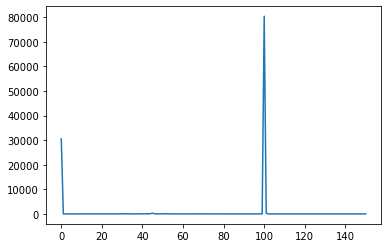

In [60]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


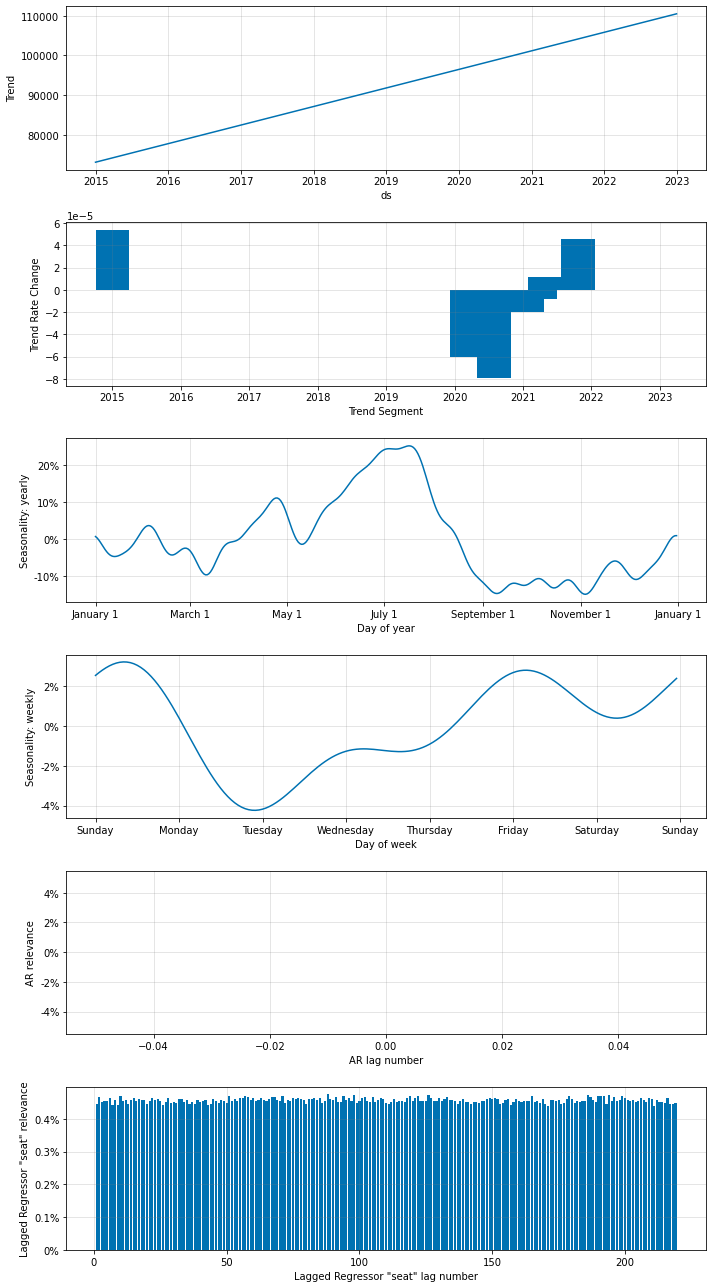

In [61]:
fig_param = m.plot_parameters()

In [62]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [63]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-12-31')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,No_int,Labor,Lunar,Summer,new_year
2922,2023-01-01,NaN,None,0,0,0,0,0,0,0,0,1
2923,2023-01-02,NaN,None,0,0,0,0,0,0,0,0,0
2924,2023-01-03,NaN,None,0,0,0,0,0,0,0,0,0
2925,2023-01-04,NaN,None,0,0,0,0,0,0,0,0,0
2926,2023-01-05,NaN,None,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3281,2023-12-26,NaN,None,0,0,0,0,0,0,0,0,0
3282,2023-12-27,NaN,None,0,0,0,0,0,0,0,0,0
3283,2023-12-28,NaN,None,0,0,0,0,0,0,0,0,0
3284,2023-12-29,NaN,None,0,0,0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 74it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


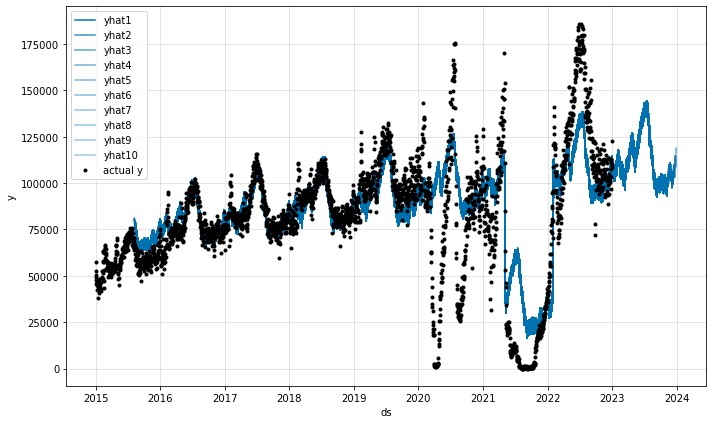

In [64]:
forecast = m.predict(future, decompose = True)
fig = m.plot(forecast)

In [65]:
#Consolidate forecast result
for i in forecast.filter(regex= ('yhat')).columns[1:]:
    forecast['yhat1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('ar\d')).columns[1:]:
    forecast['ar1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('lagged_regressor_seat')).columns[1:]:
    forecast['lagged_regressor_seat1'].update(forecast.pop(i))

In [66]:
forecast.update(forecast[['ds','yhat1']].merge(dom, 'left','ds'))

In [67]:
forecast

,ds,y,yhat1,ar1,lagged_regressor_seat1,trend,season_yearly,season_weekly,events_additive,events_multiplicative,event_Labor,event_Lunar,event_No_int,event_Summer,event_covid_1,event_covid_2,event_covid_3,event_covid_4,event_new_year
0,2015-01-01,"52,356",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,"47,811",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,"49,555",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,"57,680",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,"50,193",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,NaN,"112,996",0,0,"115,098",-648,"-1,455",0,0,0,0,0,0,0,0,0,0,0
3283,2023-12-28,NaN,"114,106",0,0,"115,111",43,"-1,049",0,0,0,0,0,0,0,0,0,0,0
3284,2023-12-29,NaN,"118,809",0,0,"115,124",578,"3,108",0,0,0,0,0,0,0,0,0,0,0
3285,2023-12-30,NaN,"116,850",0,0,"115,137",922,791,0,0,0,0,0,0,0,0,0,0,0


In [68]:
forecast.to_excel('neural_prophet_result.xlsx')